In [6]:
import shap
import xgboost
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from src.utils import get_project_root
from src.evaluation.scoring import wmape, wbias
from src.data.splitting import split_dataset, time_series_cv

In [7]:
## Functions

def forecast_bias(actual: pd.Series, forecast: pd.Series):
    return round(((forecast - actual).sum()/len(actual))*100, 2)

# Configuration

In [8]:
# Model
MODELS_FOLDER = get_project_root() / 'models'
MODEL_PATH = MODELS_FOLDER / 'xgb_caffe_bar_demand_forecast_v1.bst'
# Datasets
DATASETS_FOLDER = get_project_root() / 'data/processed'
TRAIN_DATASET_PATH = DATASETS_FOLDER / 'train_data.pkl'
VALID_DATASET_PATH = DATASETS_FOLDER / 'valid_data.pkl'
TEST_DATASET_PATH = DATASETS_FOLDER / 'test_data.pkl'
# Target
TARGET = 'sales_qty'

# Loads

## Load model

In [9]:
booster = xgboost.Booster()
booster.load_model(MODEL_PATH)
if booster.attr('feature_names') is not None: 
    booster.feature_names = booster.attr('feature_names').split('|')  

## Load datasets

In [10]:
train_dataset = pd.read_pickle(TRAIN_DATASET_PATH)  
valid_dataset = pd.read_pickle(VALID_DATASET_PATH)  
test_dataset = pd.read_pickle(TEST_DATASET_PATH)  

In [11]:
train_dataset.loc[:, 'sample'] = 'train'
valid_dataset.loc[:, 'sample'] = 'valid'
test_dataset.loc[:, 'sample'] = 'test'

In [12]:
dataset = pd.concat([train_dataset, valid_dataset, test_dataset])

In [13]:
train_mask = (dataset['sample'] == 'train')
valid_mask = (dataset['sample'] == 'valid')
test_mask = (dataset['sample'] == 'test')

# Predict

In [14]:
dataset.loc[:, 'prediction'] = booster.predict(xgboost.DMatrix(dataset[booster.feature_names]), iteration_range = (0, booster.best_iteration))
dataset.loc[:, 'error_diff'] = dataset['prediction'] - dataset['sales_qty']
dataset.loc[:, 'abs_diff'] = np.abs(dataset['prediction'] - dataset['sales_qty'])

# Evaluation

## Total metrics

In [15]:
ds = {
    'Train': train_mask,
    'Valid': valid_mask,
    'Test': test_mask
}

for ds, mask in ds.items():
    print(f"{ds} WMAPE:", wmape(dataset[mask]['sales_qty'], dataset[mask]['prediction']))
    print(f"{ds} WBias:", wbias(dataset[mask]['sales_qty'], dataset[mask]['prediction']))
    print(f"{ds} forecast bias:", forecast_bias(dataset[mask]['sales_qty'], dataset[mask]['prediction']))

Train WMAPE: 42.47
Train WBias: -0.01
Train forecast bias: -0.04
Valid WMAPE: 44.82
Valid WBias: 1.37
Valid forecast bias: 8.66
Test WMAPE: 44.2
Test WBias: -0.57
Test forecast bias: -3.89


## Visualisation of scores

In [16]:

wmape_train_valid_scores = dataset[train_mask | valid_mask].groupby('item_name').apply(lambda x: pd.Series({'bias': wbias(x['sales_qty'], x['prediction']), 
                                                                'wmape': wmape(x['sales_qty'], x['prediction']),
                                                               'total_sales': x['sales_qty'].sum(),
                                                               'total_prediction': x['prediction'].sum()})
                                                                ).sort_values(by='total_sales', ascending=False).reset_index()
wmape_test_scores = dataset[test_mask].groupby('item_name').apply(lambda x: pd.Series({'bias': wbias(x['sales_qty'], x['prediction']), 
                                                                'wmape': wmape(x['sales_qty'], x['prediction']),
                                                                'total_sales': x['sales_qty'].sum(),
                                                                'total_prediction': x['prediction'].sum()})
                                                                ).sort_values(by='total_sales', ascending=False).reset_index()

(0.0, 186.76850000000002)

Glyph 154 (\x9a) missing from current font.
Glyph 158 (\x9e) missing from current font.
Glyph 154 (\x9a) missing from current font.
Glyph 158 (\x9e) missing from current font.


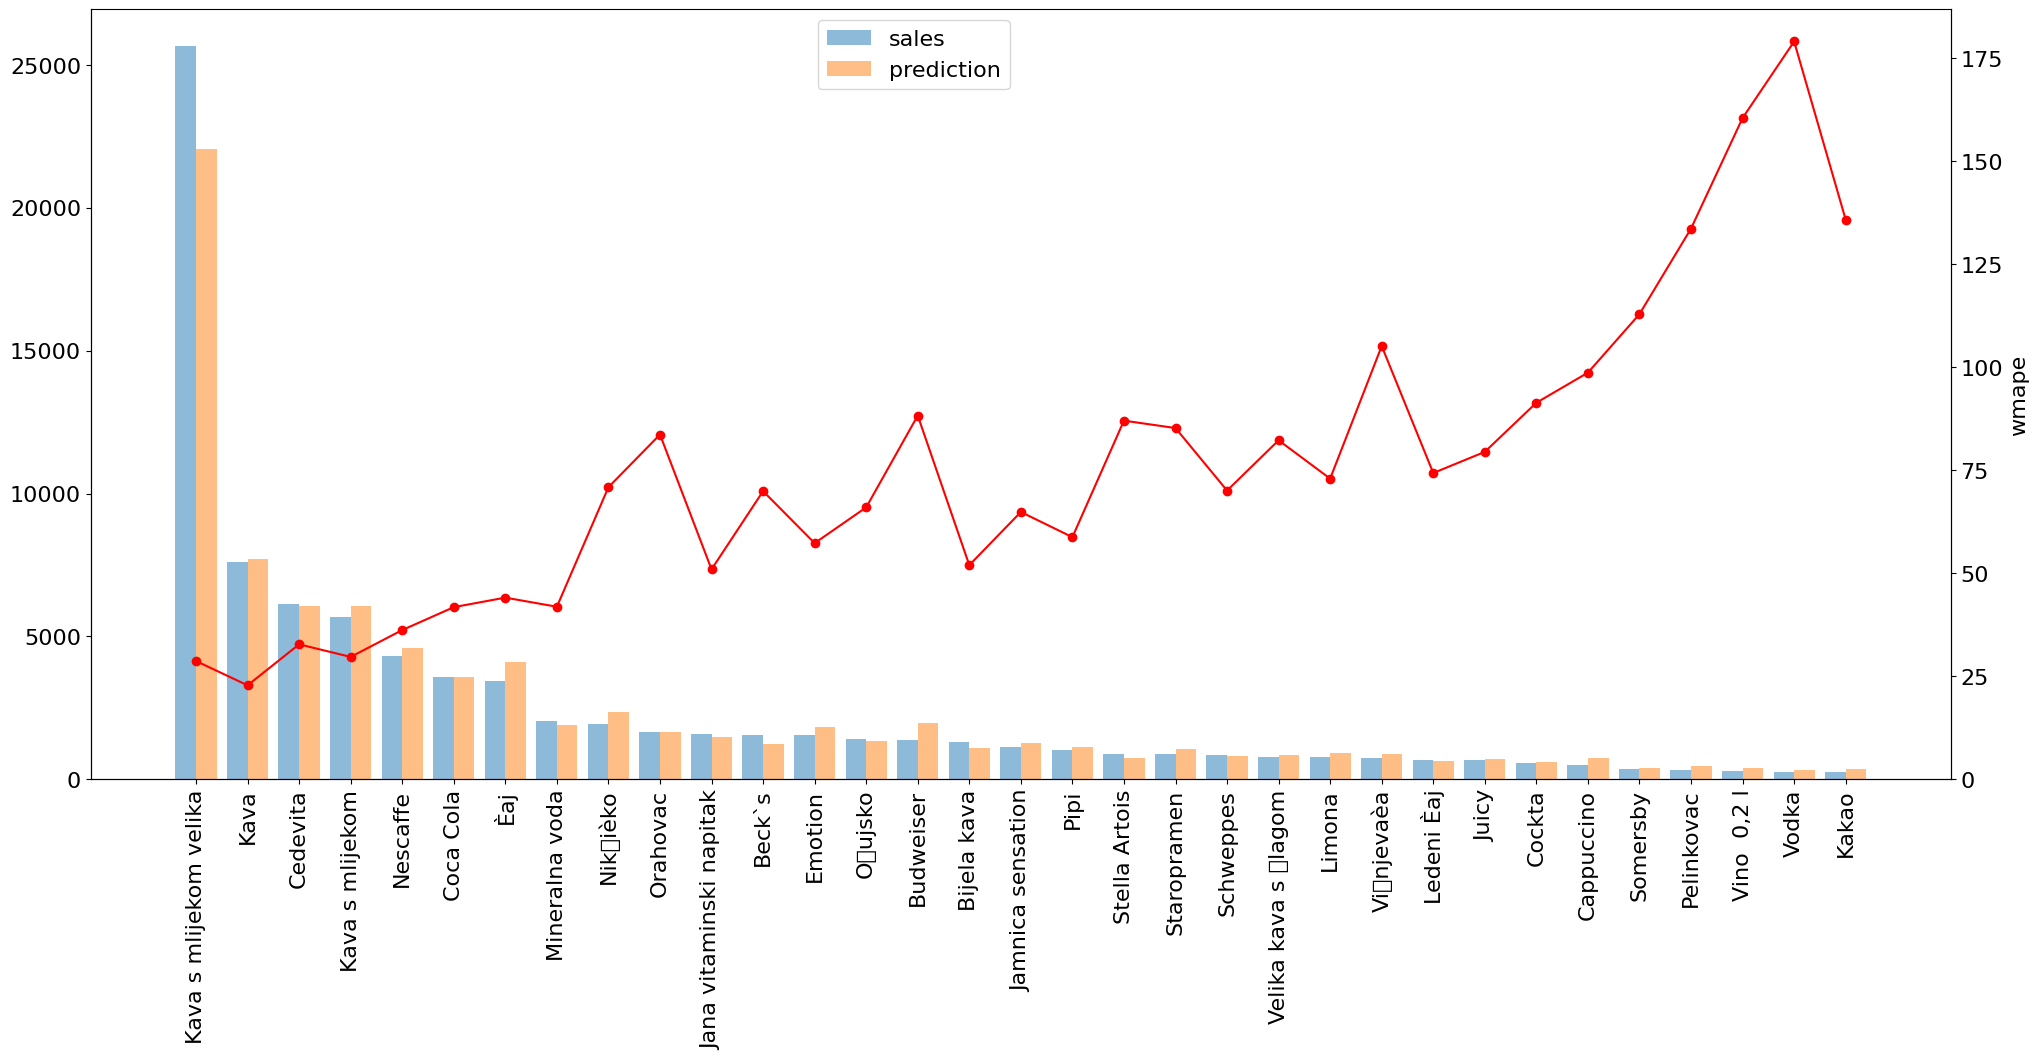

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(24,10))

X_axis = np.arange(len(wmape_test_scores['item_name']))
p1 = ax.bar(X_axis - 0.2, wmape_test_scores['total_sales'], width=0.4, alpha=0.5, label='sales')
p2 = ax.bar(X_axis + 0.2, wmape_test_scores['total_prediction'], width=0.4, alpha=0.5, label='prediction')
ax.spines['top'].set_visible(False)
ax.set_xticks(X_axis)
ax.set_xticklabels(wmape_test_scores['item_name'], rotation=90, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(bbox_to_anchor=(0.5, 1), fontsize=16)

ax2 = ax.twinx()
p3 = ax2.plot(X_axis, wmape_test_scores['wmape'], color = 'red', marker='o', label='wmape')
ax2.set_ylabel('wmape', fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.set_ylim([0, ax2.get_ylim()[1]])


In [18]:
def plot_examples(dataset, 
                  wmape_train_valid_scores, 
                  wmape_test_scores,
                  train_mask,
                  valid_mask,
                  test_mask,
                  sort_by,
                  sort_ascending,
                  num_examples=5):
    for item in wmape_test_scores.sort_values(ascending=sort_ascending, by=sort_by)['item_name'][:num_examples]:
        print(f"#### Item: {item} ####")
        print("## Train & valid scores: ")
        print(f"WMAPE: {wmape_train_valid_scores.loc[(wmape_train_valid_scores.item_name == item), 'wmape'].values[0]}")
        print(f"Bias: {wmape_train_valid_scores.loc[(wmape_train_valid_scores.item_name == item), 'bias'].values[0]}")
        print("## Test scores: ")
        if not wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'wmape'].empty:
            print(f"WMAPE: {wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'wmape'].values[0]}")
            print(f"Bias: {wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'bias'].values[0]}")
            dataset[(train_mask | valid_mask) & (dataset.item_name == item)].plot(y=['sales_qty', 'prediction'], figsize=(16,9))
            dataset[(test_mask) & (dataset.item_name == item)].plot(y=['sales_qty', 'prediction'], figsize=(16,9), linewidth=3) # marker='o',
            #dataset[(test_mask) & (dataset.item_name == item)].plot(y=['error_diff'], figsize=(16,9), kind='kde', bins=100, grid=True)
            plt.show()
        

## Predictions time series  plot


### Examples with highest sales in test set

#### Item: Kava s mlijekom velika ####
## Train & valid scores: 
WMAPE: 19.95
Bias: -2.75
## Test scores: 
WMAPE: 28.68
Bias: -14.09


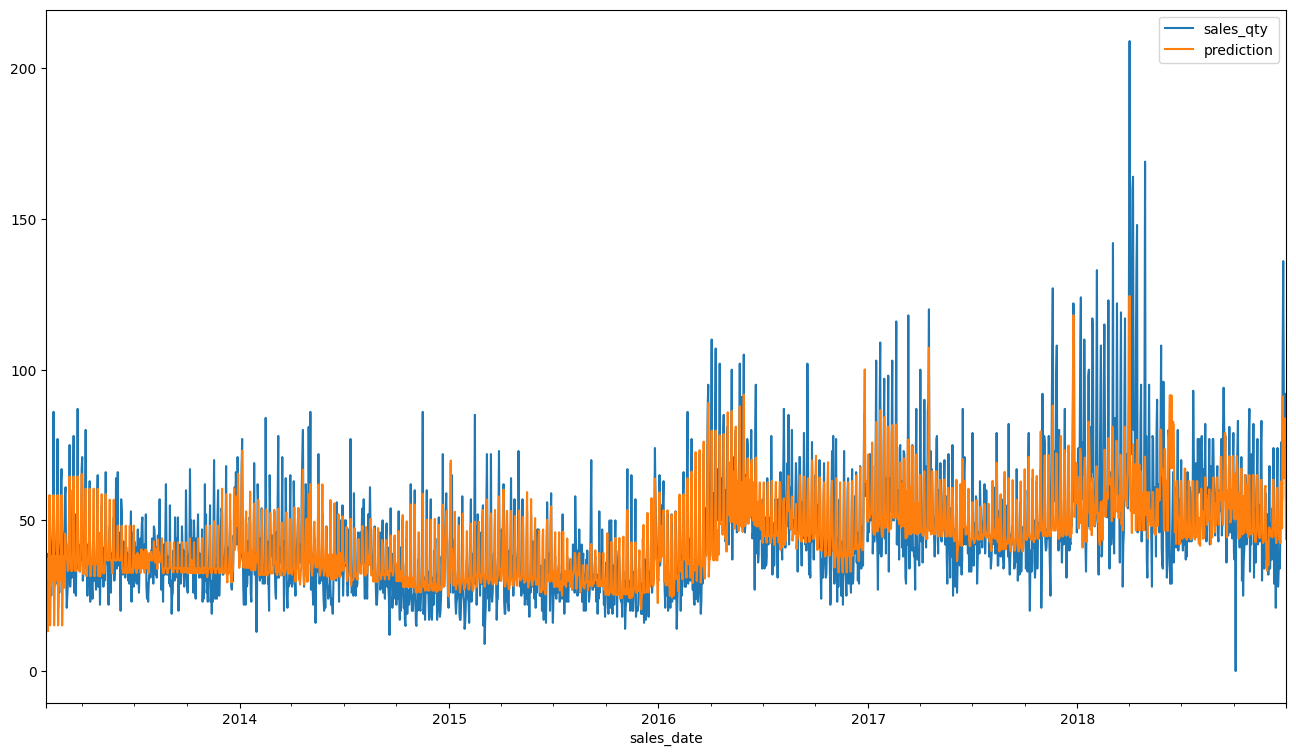

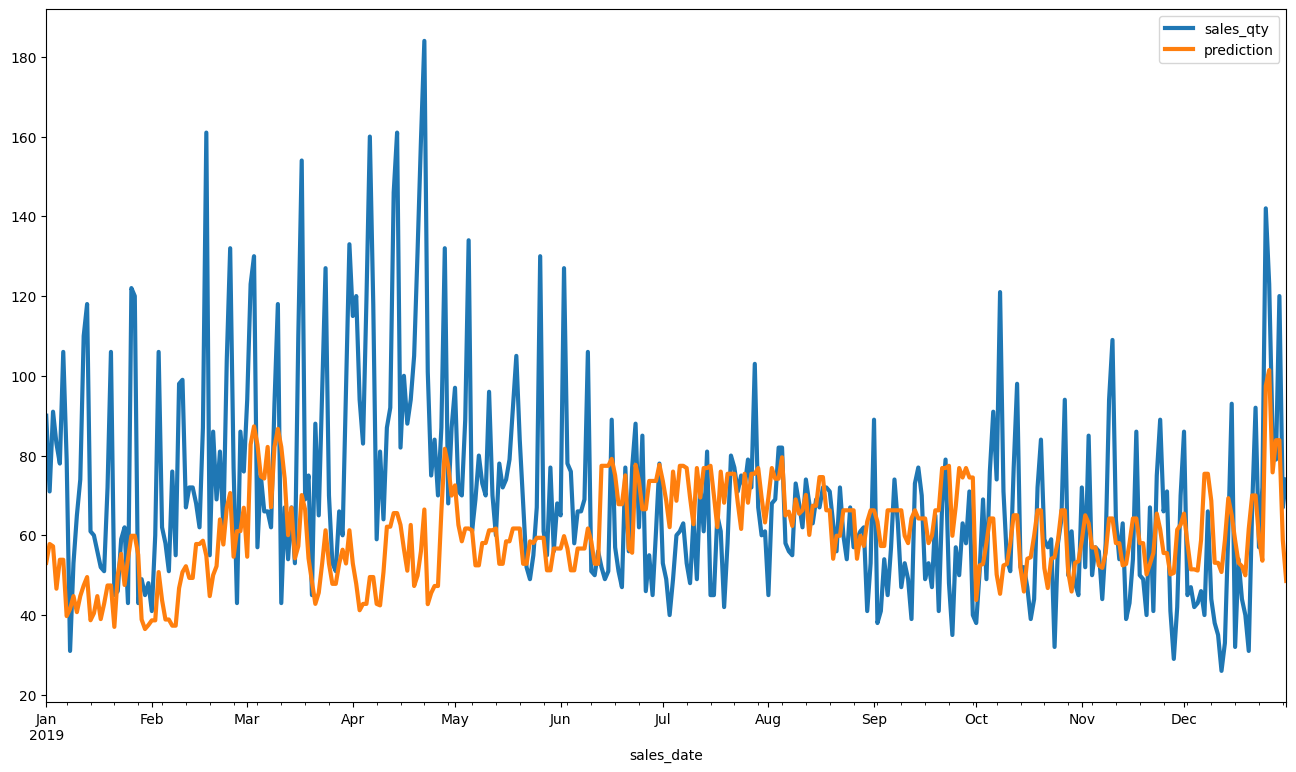

#### Item: Kava ####
## Train & valid scores: 
WMAPE: 26.08
Bias: 0.86
## Test scores: 
WMAPE: 22.79
Bias: 1.07


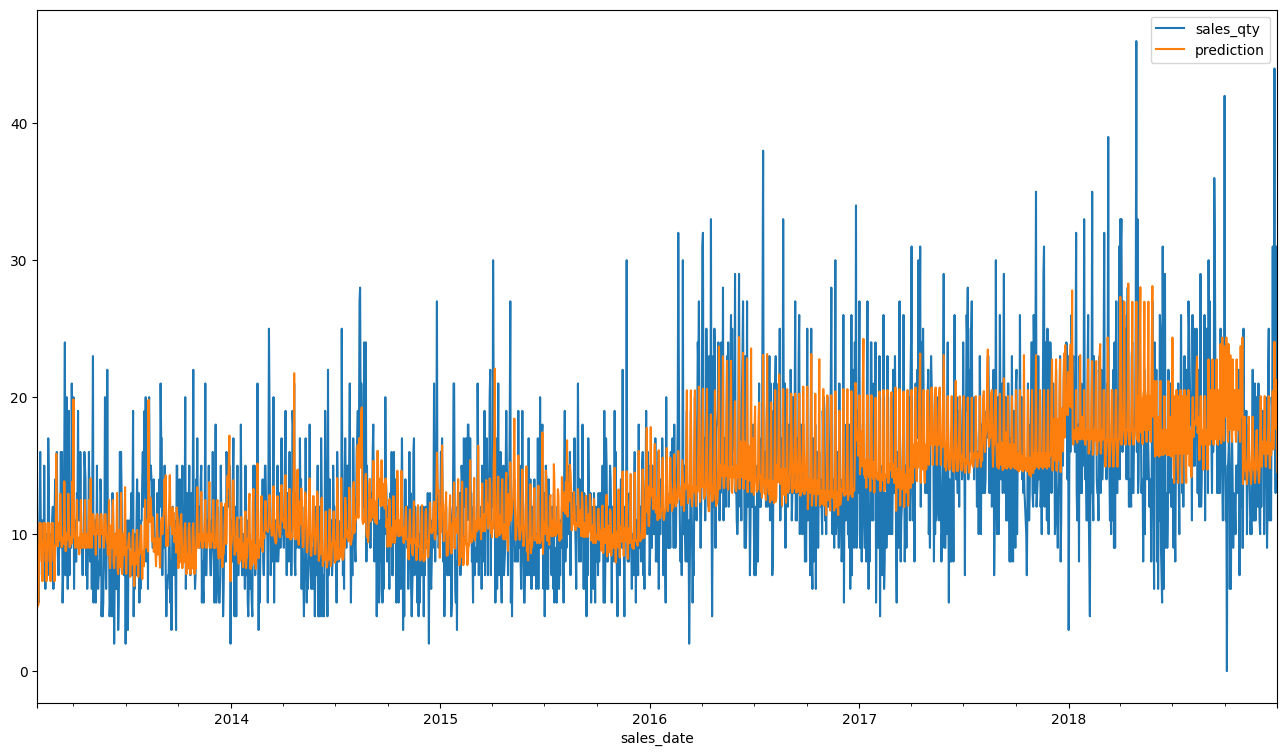

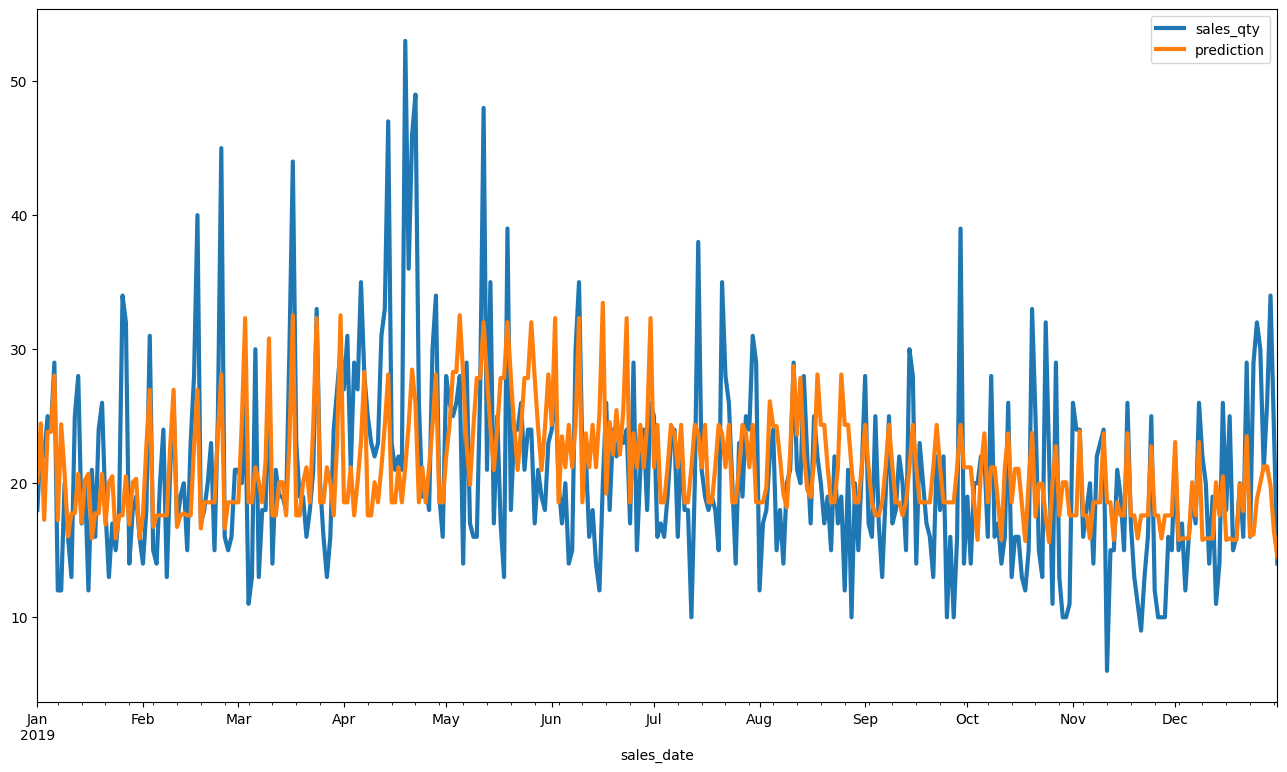

#### Item: Cedevita ####
## Train & valid scores: 
WMAPE: 34.68
Bias: -4.56
## Test scores: 
WMAPE: 32.73
Bias: -1.25


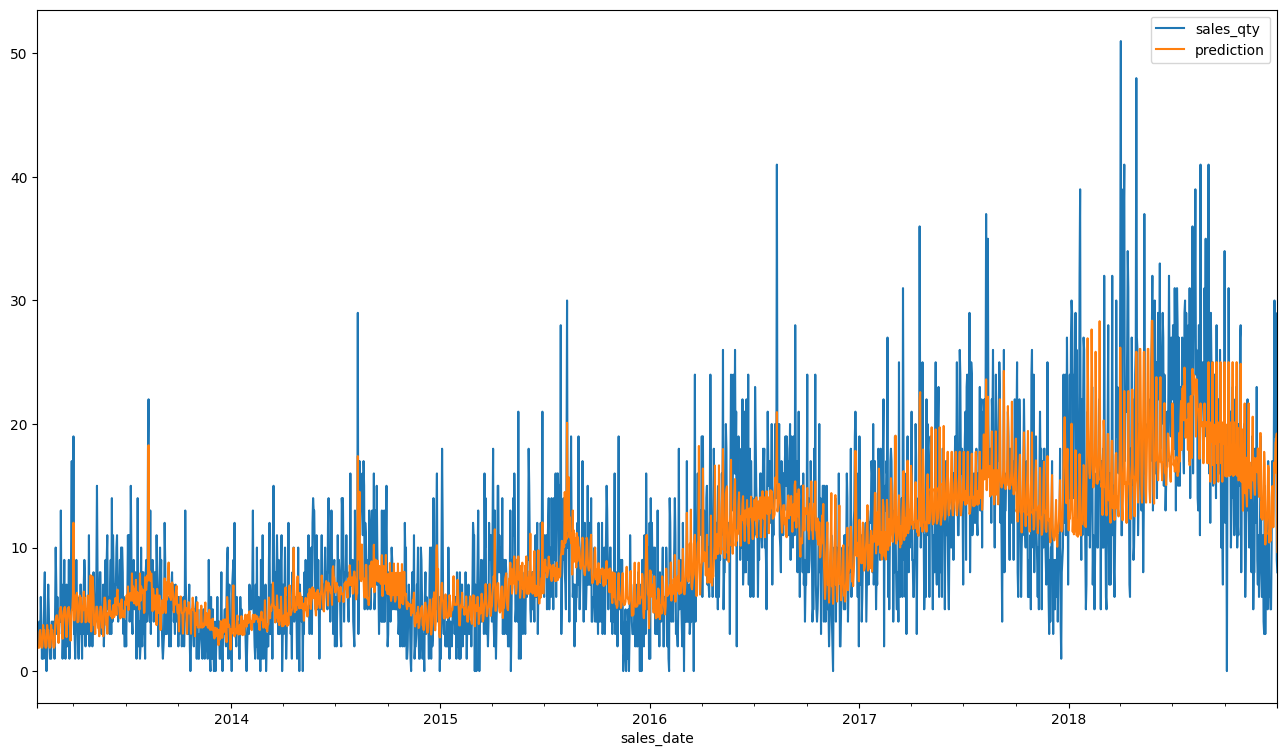

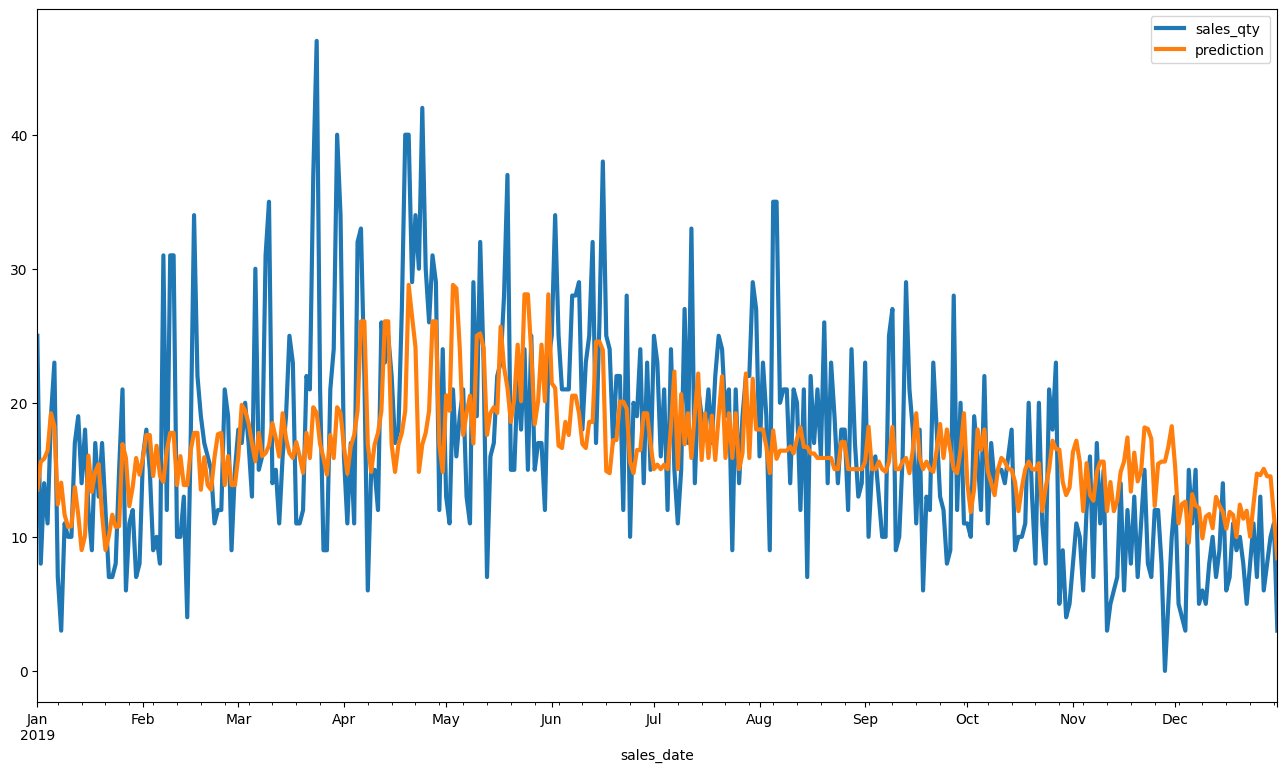

#### Item: Kava s mlijekom ####
## Train & valid scores: 
WMAPE: 33.06
Bias: 3.31
## Test scores: 
WMAPE: 29.68
Bias: 6.98


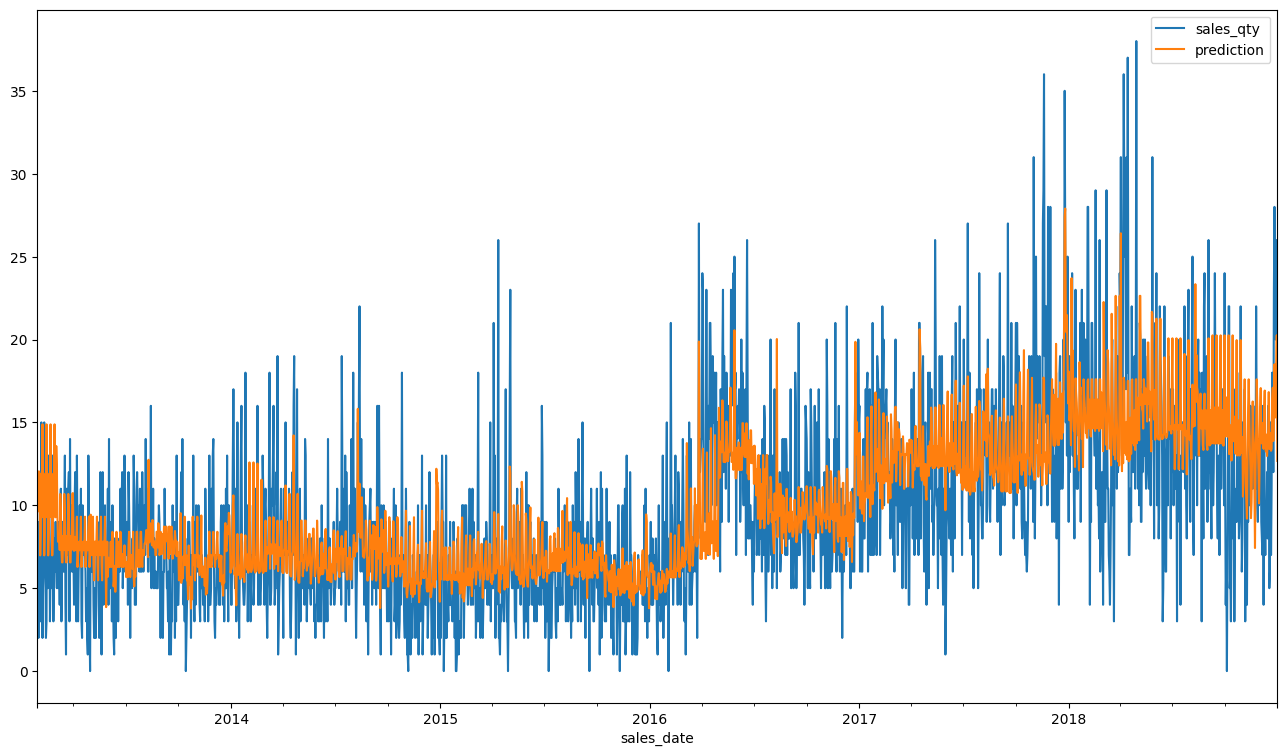

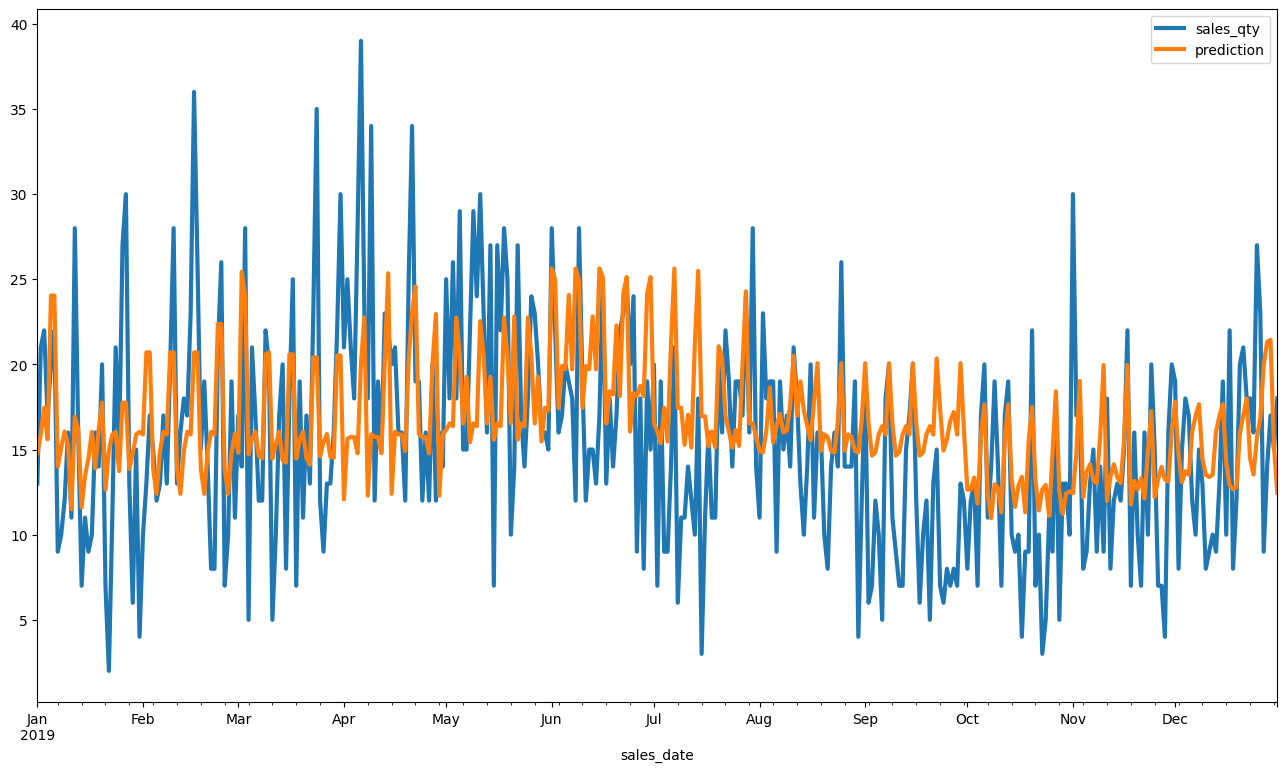

#### Item: Nescaffe ####
## Train & valid scores: 
WMAPE: 34.0
Bias: 0.39
## Test scores: 
WMAPE: 36.19
Bias: 6.43


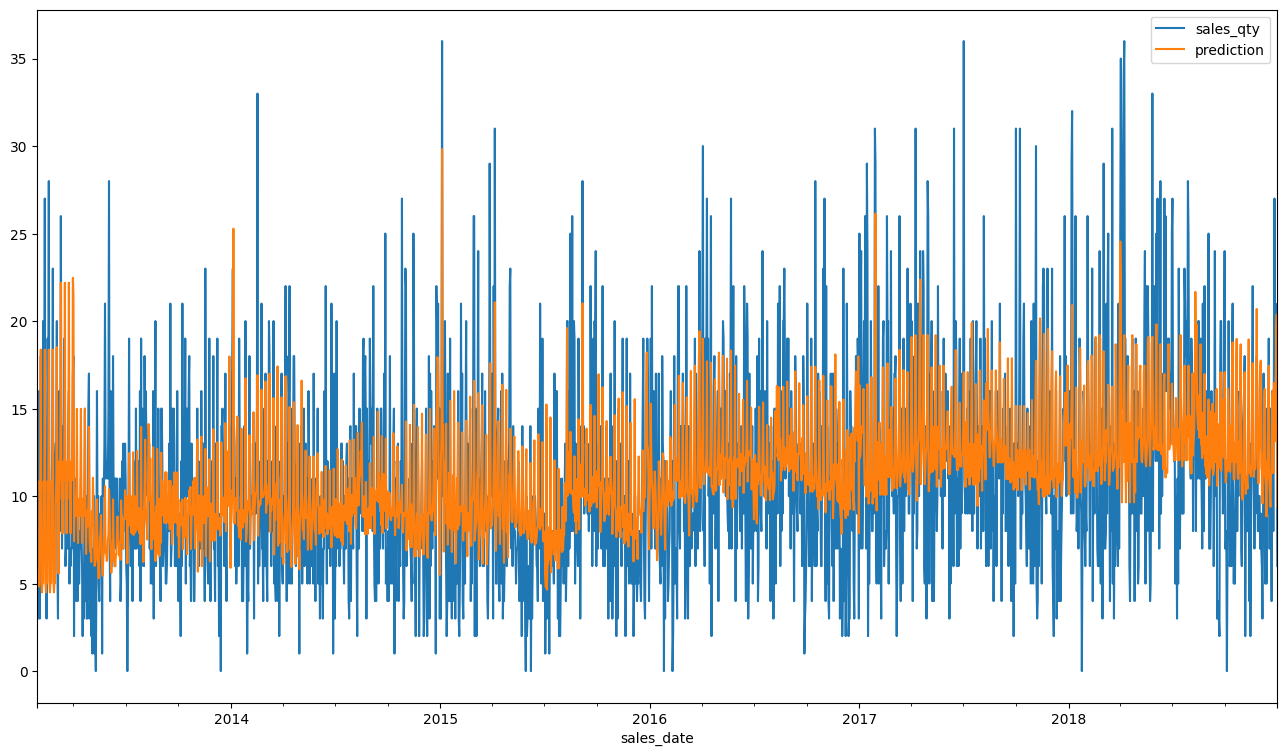

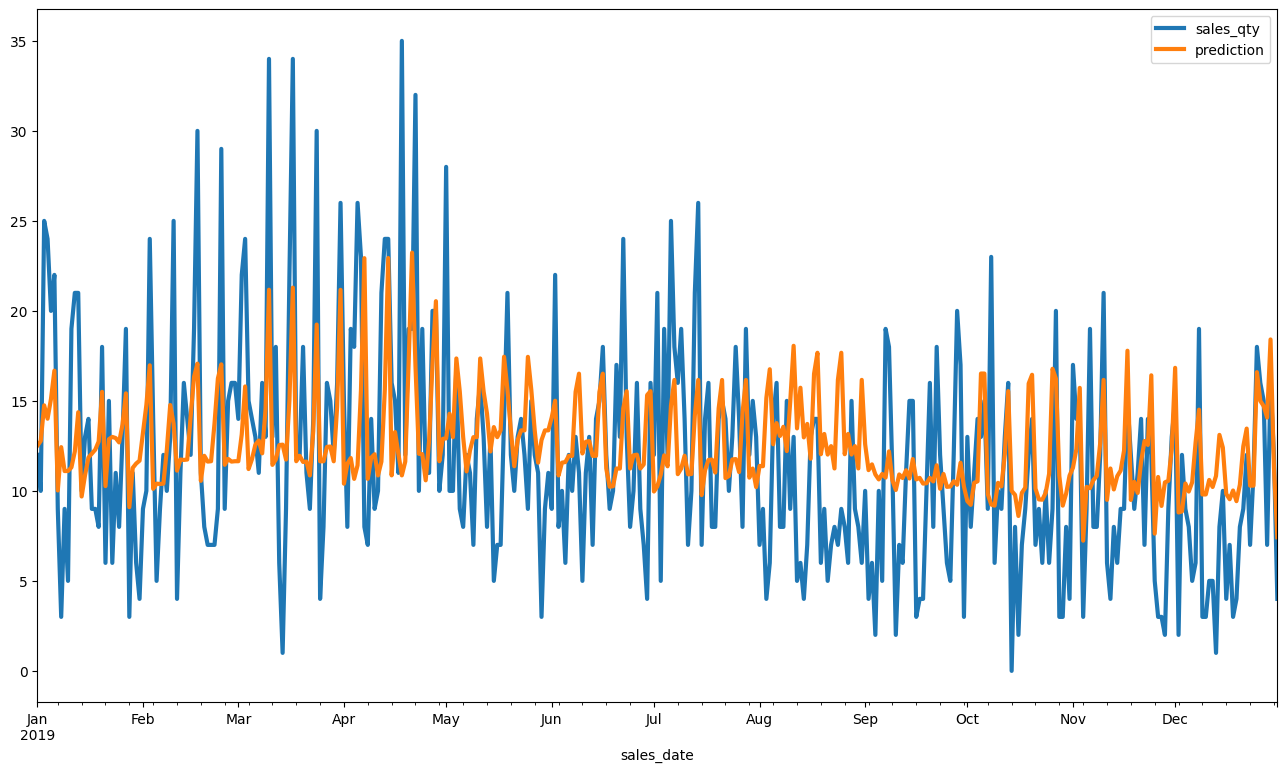

In [19]:
sort_by = 'total_sales'
sort_ascending = False
plot_examples(dataset, 
              wmape_train_valid_scores, 
              wmape_test_scores,
              train_mask,
              valid_mask,
              test_mask,
              sort_by,
              sort_ascending,
              num_examples=5)

### Examples with best test set WMAPE 

#### Item: Kava ####
## Train & valid scores: 
WMAPE: 26.08
Bias: 0.86
## Test scores: 
WMAPE: 22.79
Bias: 1.07


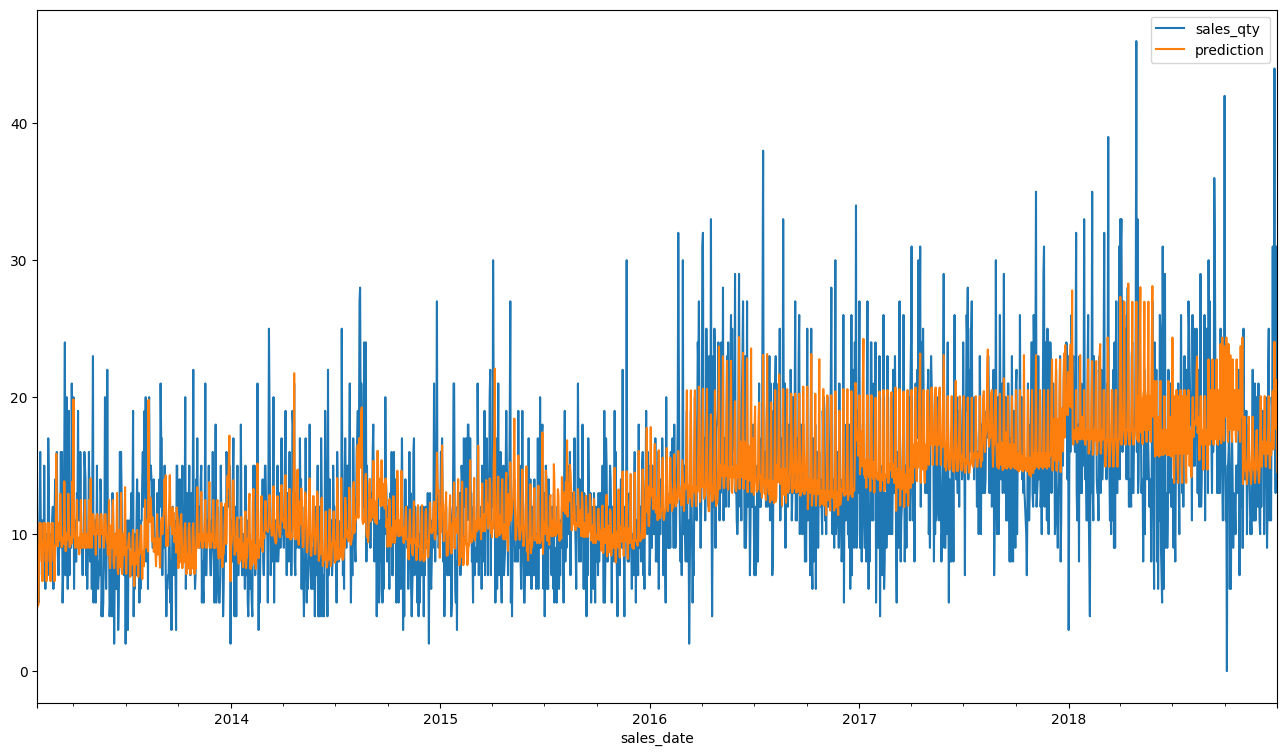

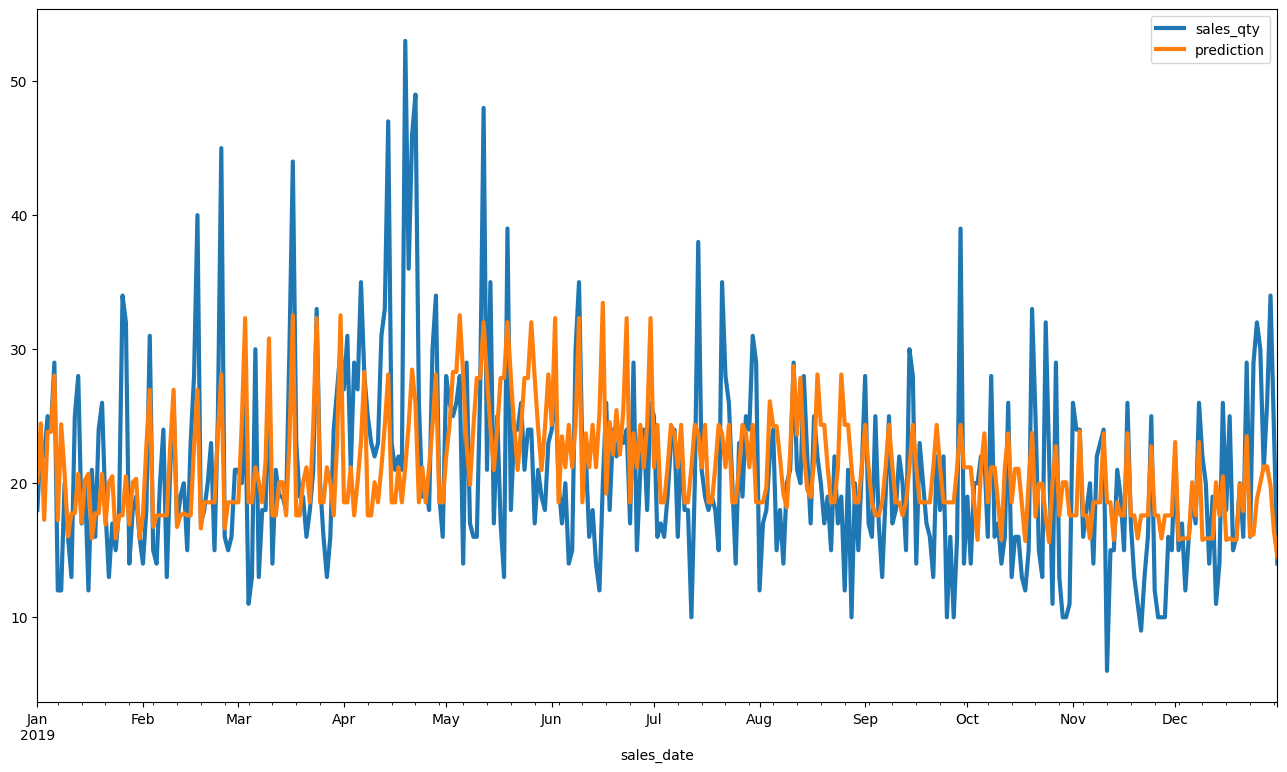

#### Item: Kava s mlijekom velika ####
## Train & valid scores: 
WMAPE: 19.95
Bias: -2.75
## Test scores: 
WMAPE: 28.68
Bias: -14.09


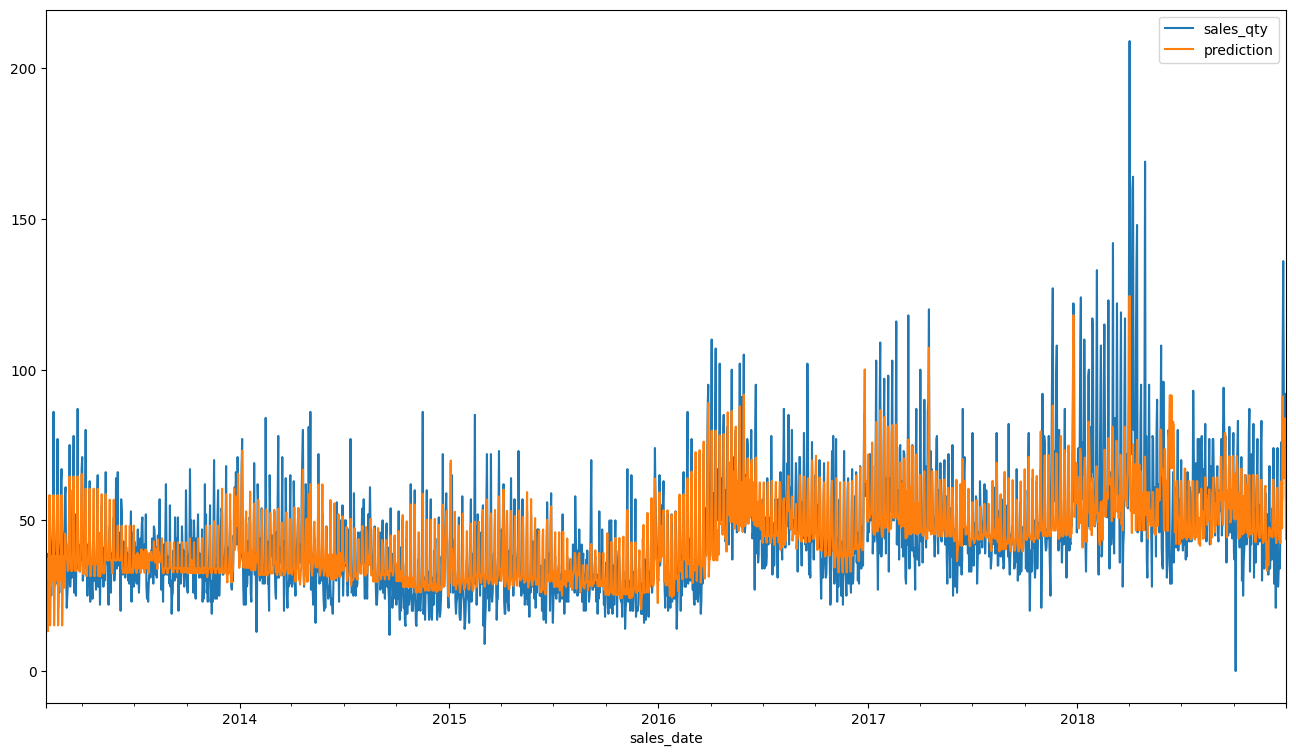

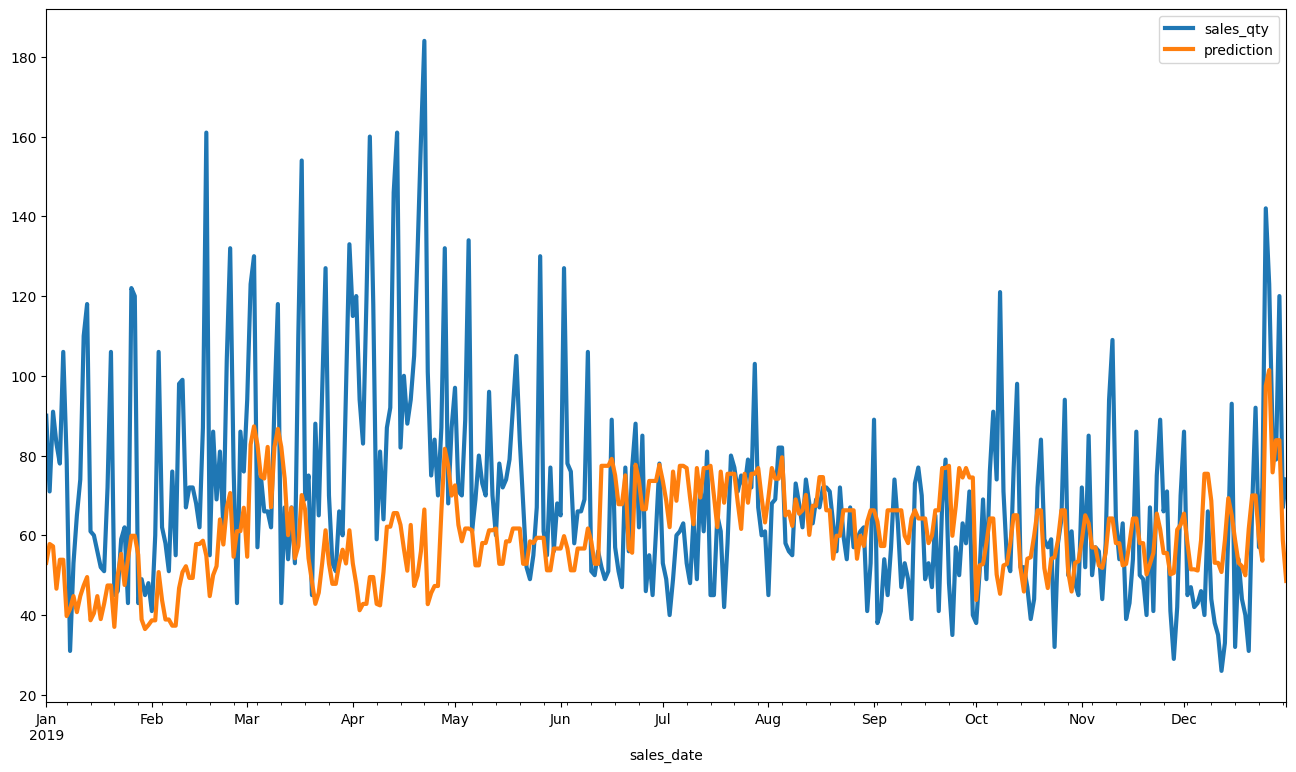

#### Item: Kava s mlijekom ####
## Train & valid scores: 
WMAPE: 33.06
Bias: 3.31
## Test scores: 
WMAPE: 29.68
Bias: 6.98


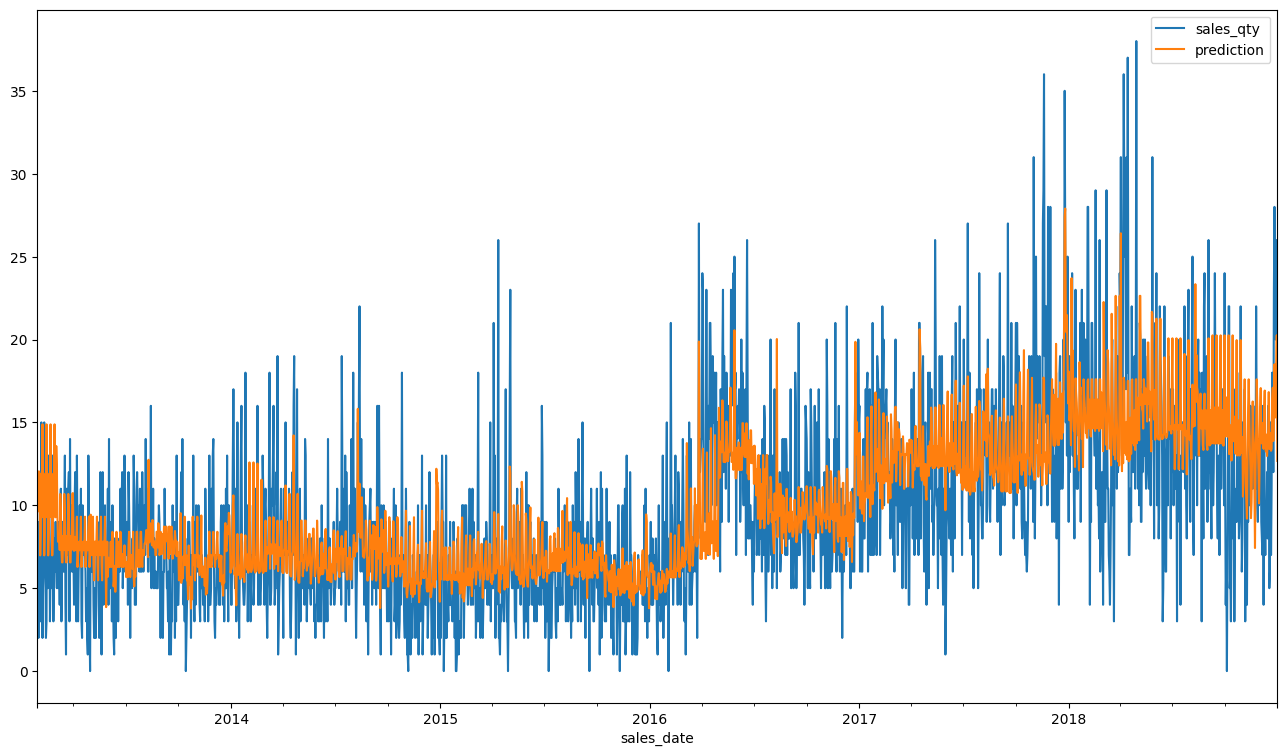

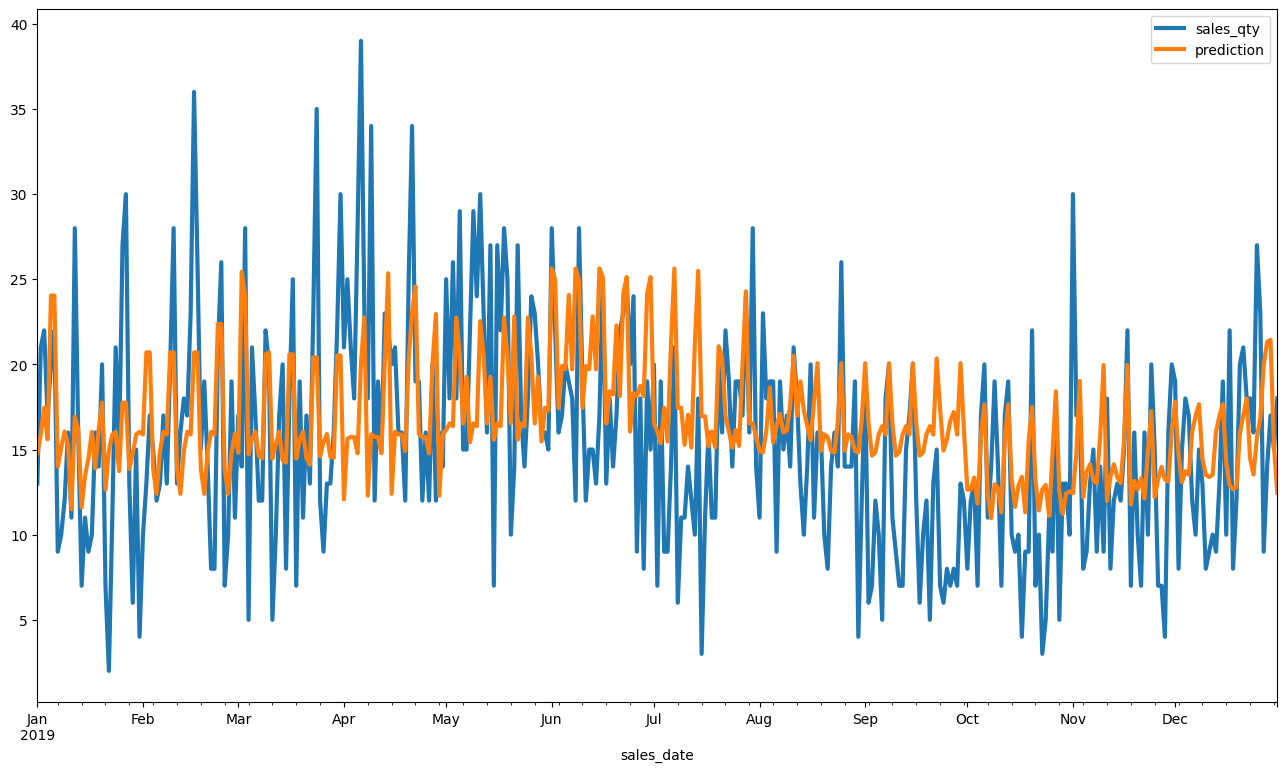

#### Item: Cedevita ####
## Train & valid scores: 
WMAPE: 34.68
Bias: -4.56
## Test scores: 
WMAPE: 32.73
Bias: -1.25


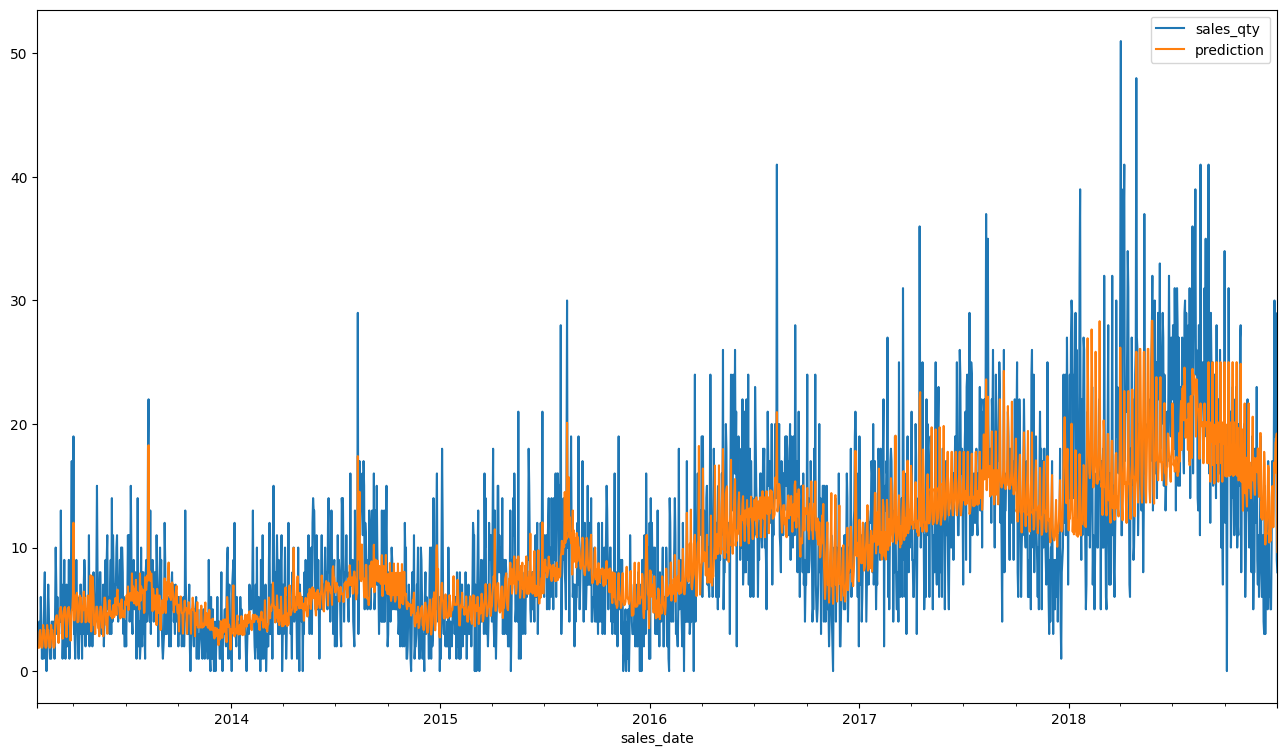

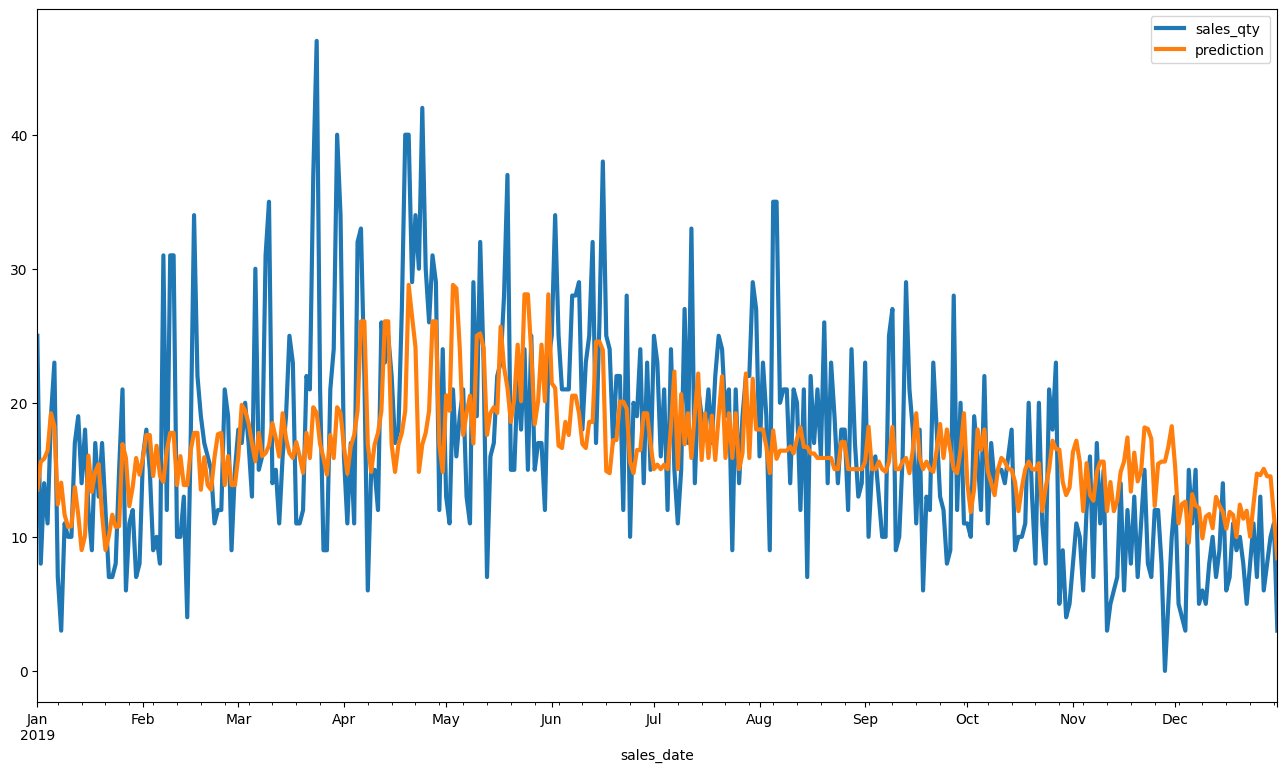

#### Item: Nescaffe ####
## Train & valid scores: 
WMAPE: 34.0
Bias: 0.39
## Test scores: 
WMAPE: 36.19
Bias: 6.43


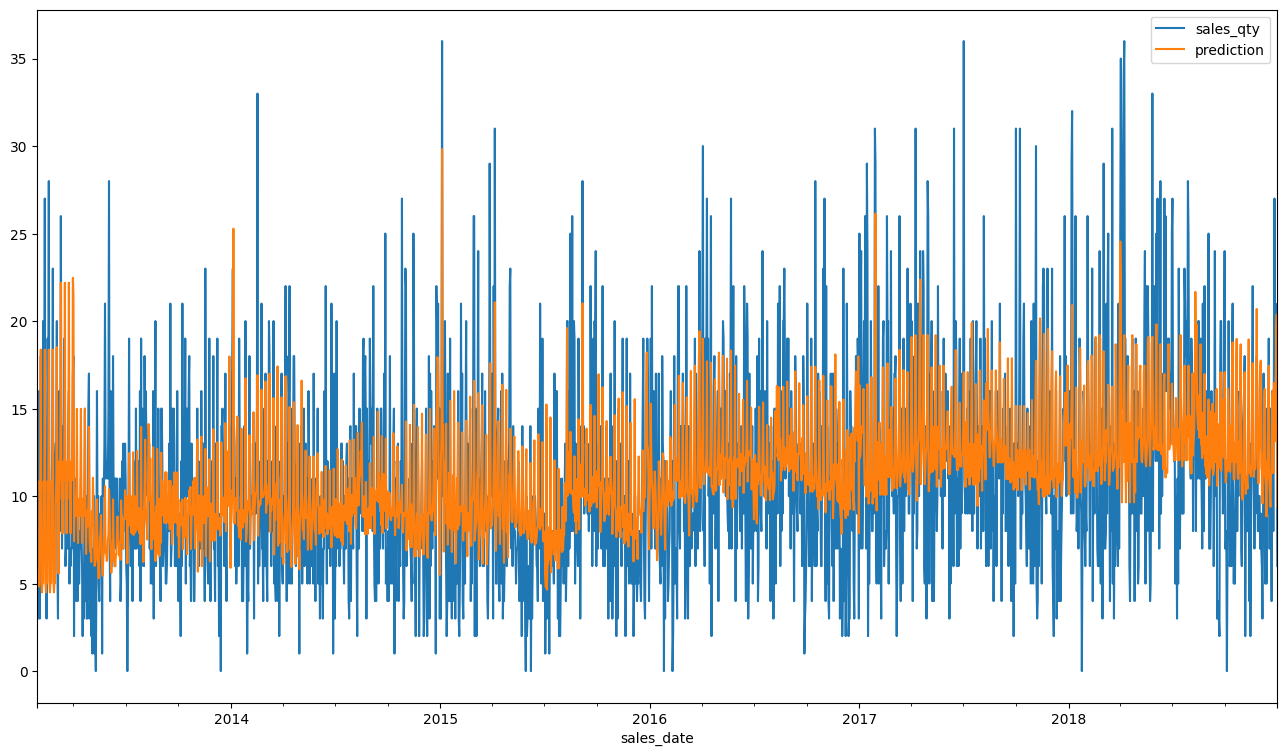

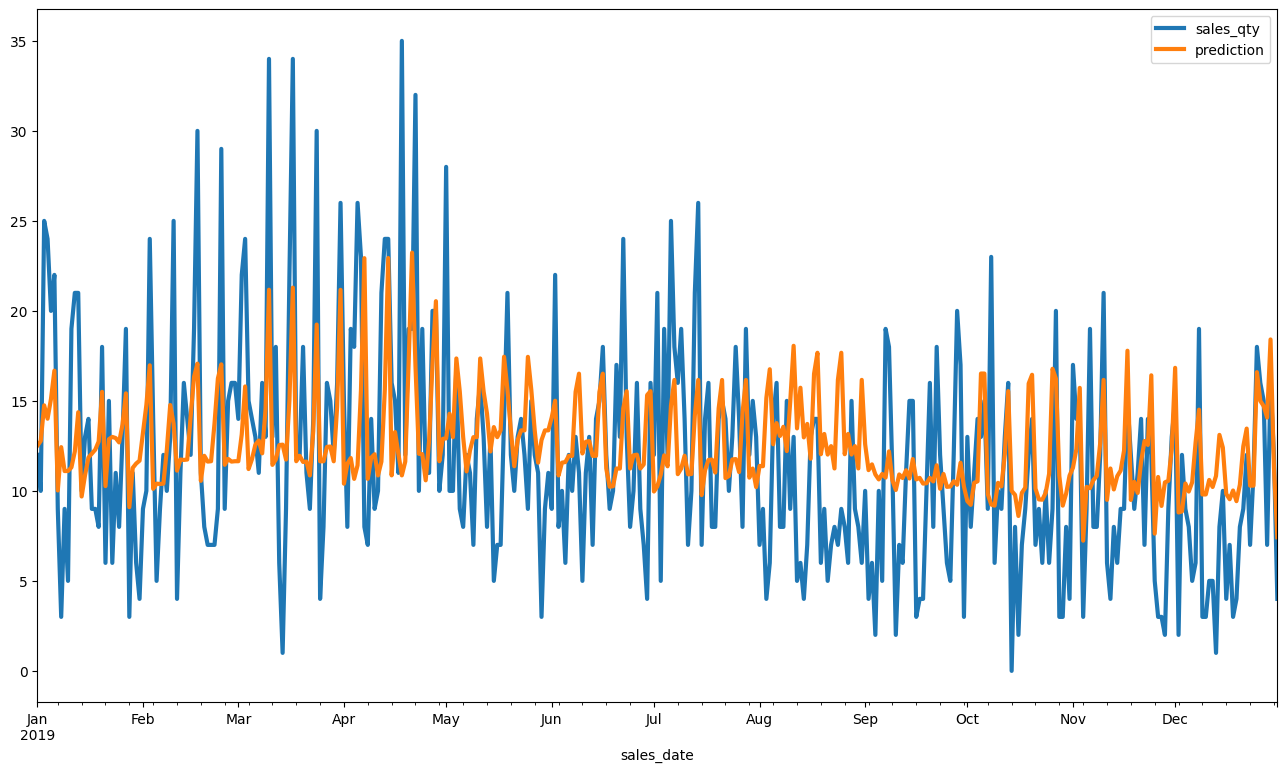

In [20]:
sort_by = 'wmape'
sort_ascending = True
plot_examples(dataset, 
              wmape_train_valid_scores, 
              wmape_test_scores,
              train_mask,
              valid_mask,
              test_mask,
              sort_by,
              sort_ascending,
              num_examples=5)

### Examples with worst test set WMAPE

#### Item: Vodka ####
## Train & valid scores: 
WMAPE: 159.82
Bias: 15.44
## Test scores: 
WMAPE: 178.96
Bias: 29.8


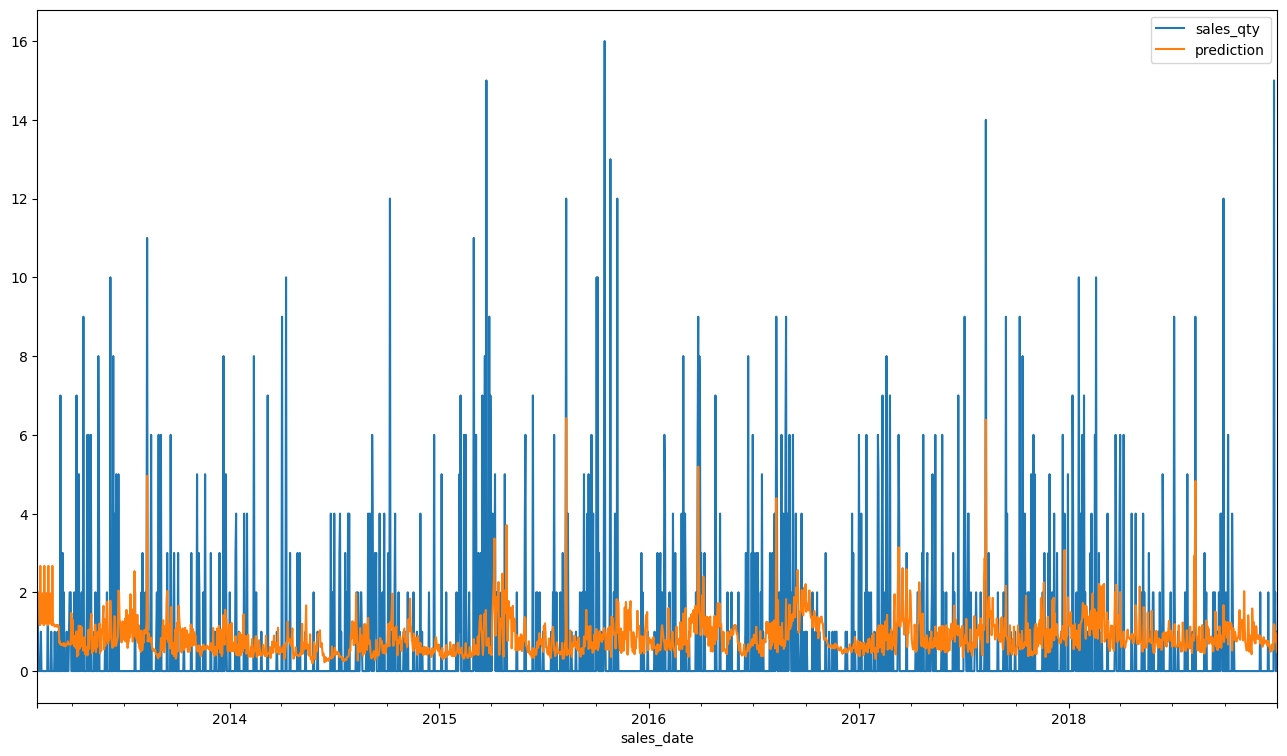

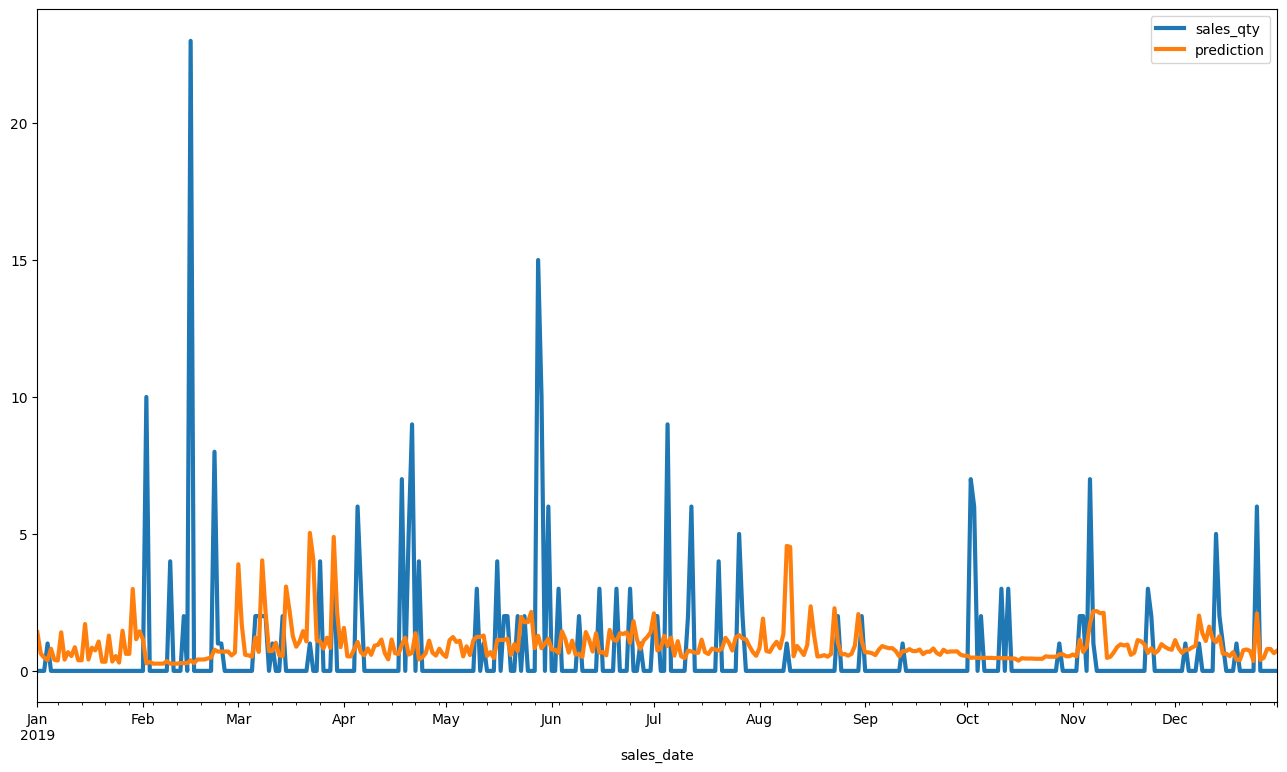

#### Item: Vino  0,2 l ####
## Train & valid scores: 
WMAPE: 123.81
Bias: -0.81
## Test scores: 
WMAPE: 160.39
Bias: 34.39


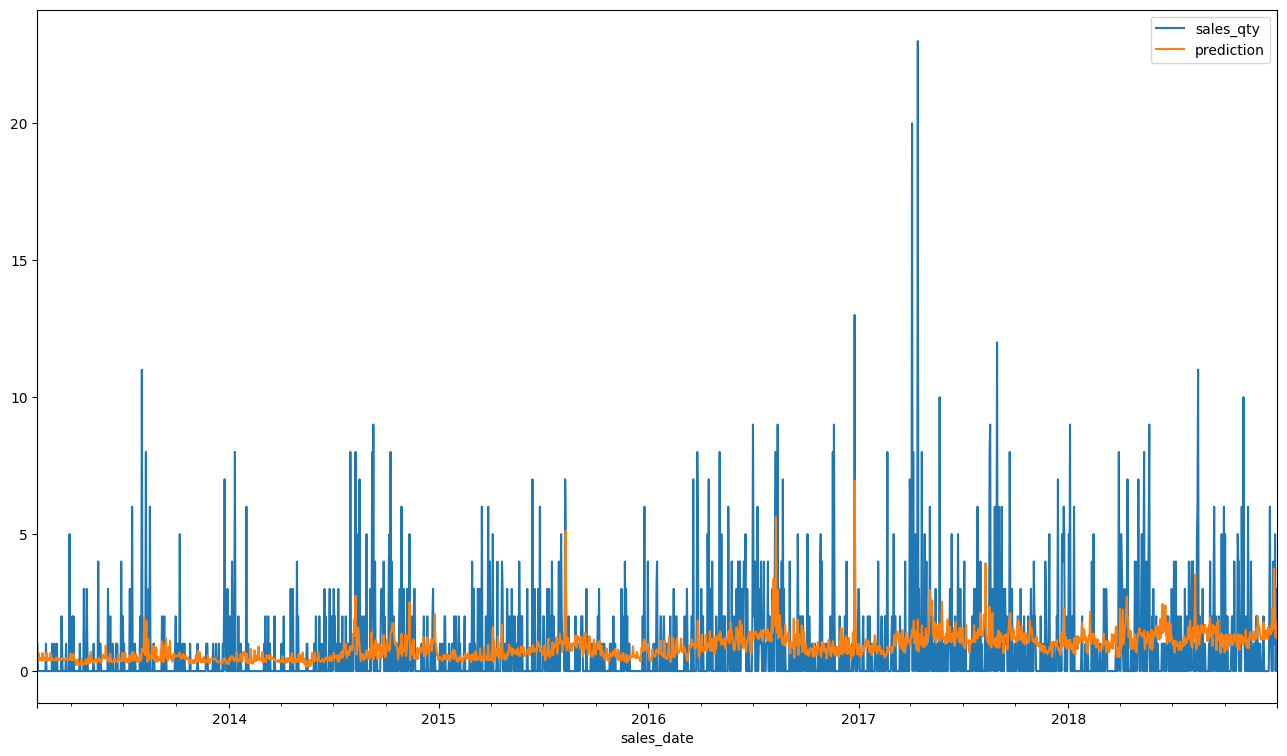

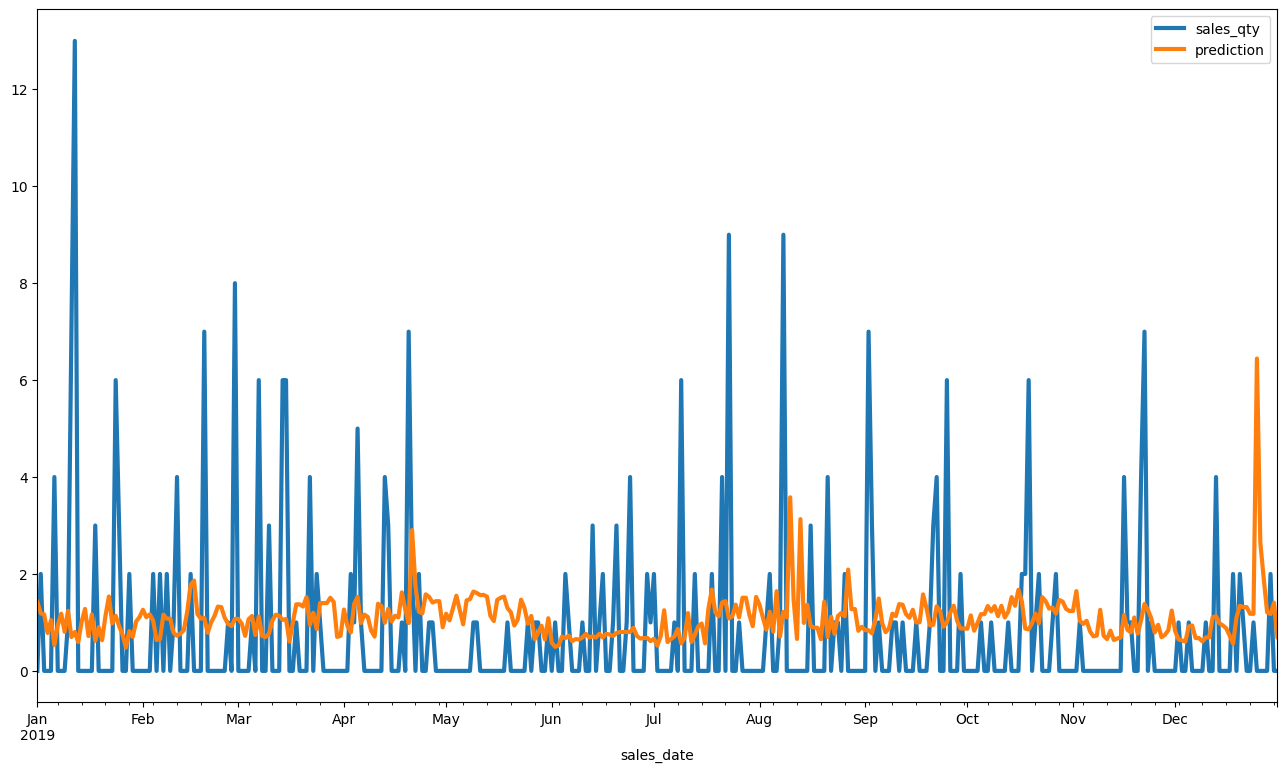

#### Item: Kakao ####
## Train & valid scores: 
WMAPE: 94.75
Bias: 7.67
## Test scores: 
WMAPE: 135.74
Bias: 53.12


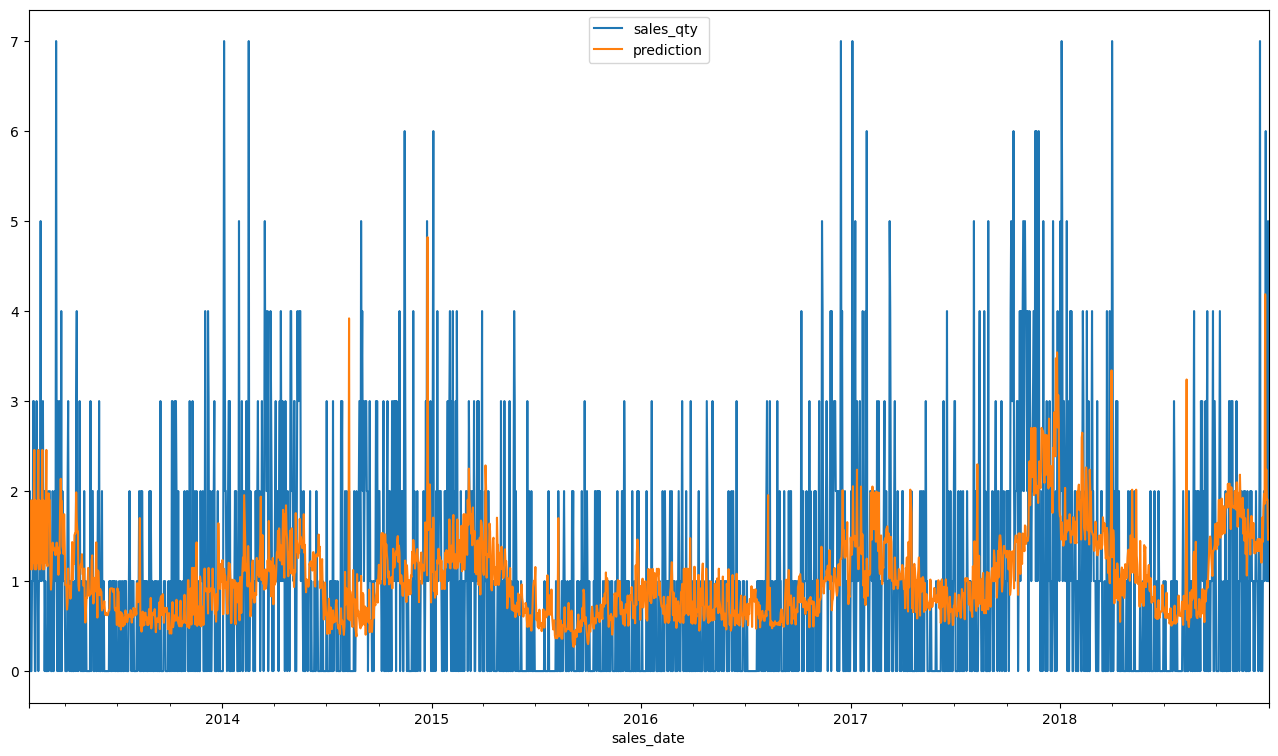

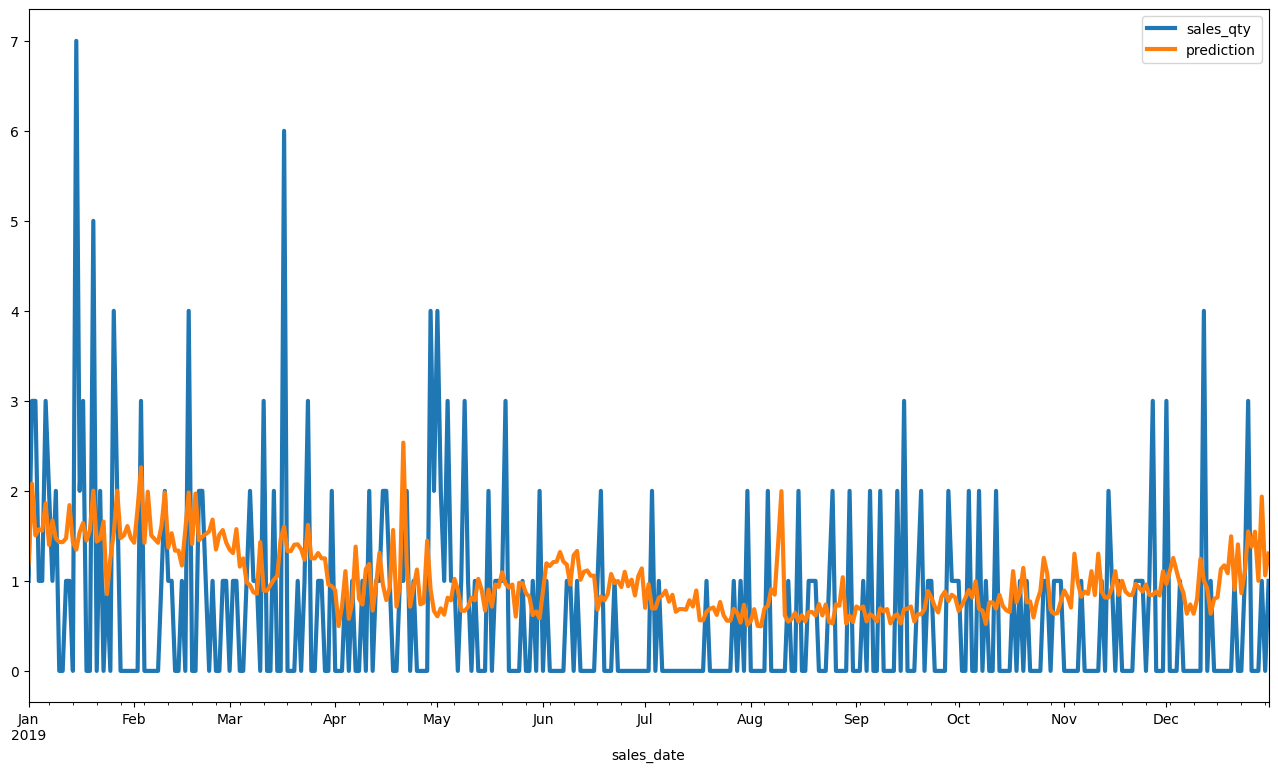

#### Item: Pelinkovac ####
## Train & valid scores: 
WMAPE: 145.17
Bias: 15.48
## Test scores: 
WMAPE: 133.58
Bias: 38.97


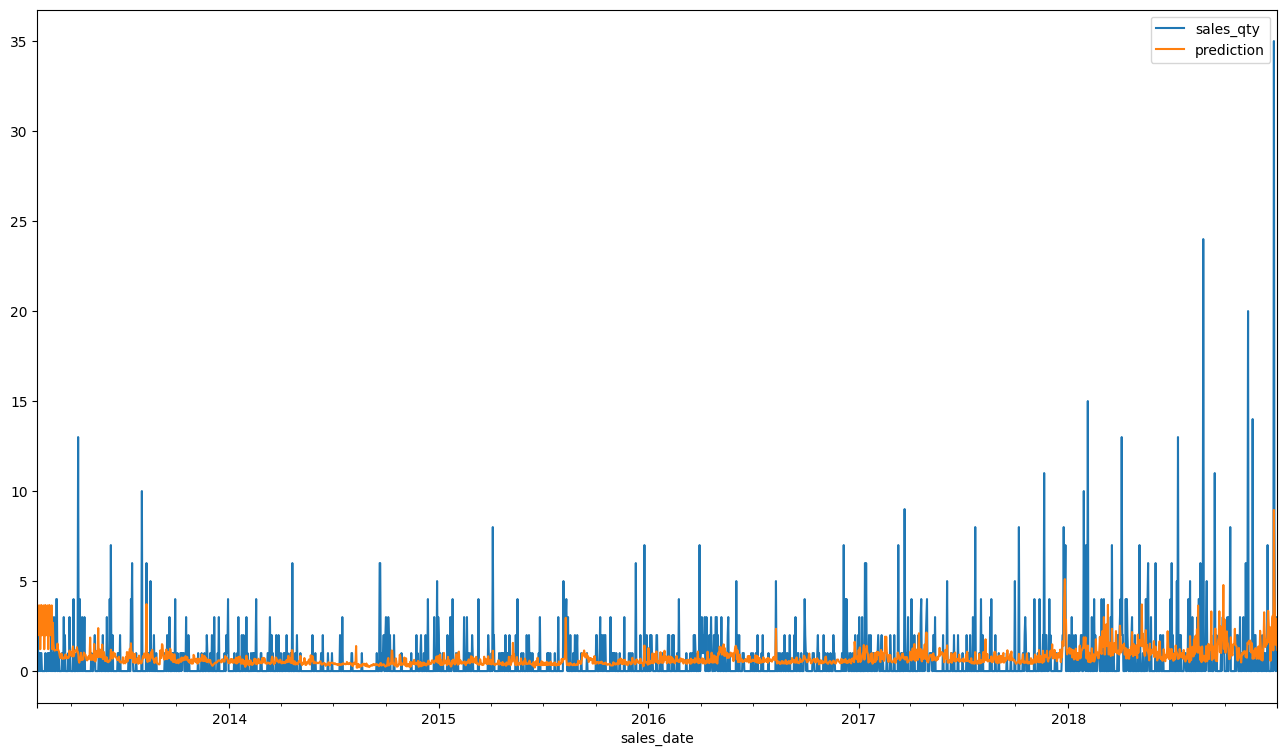

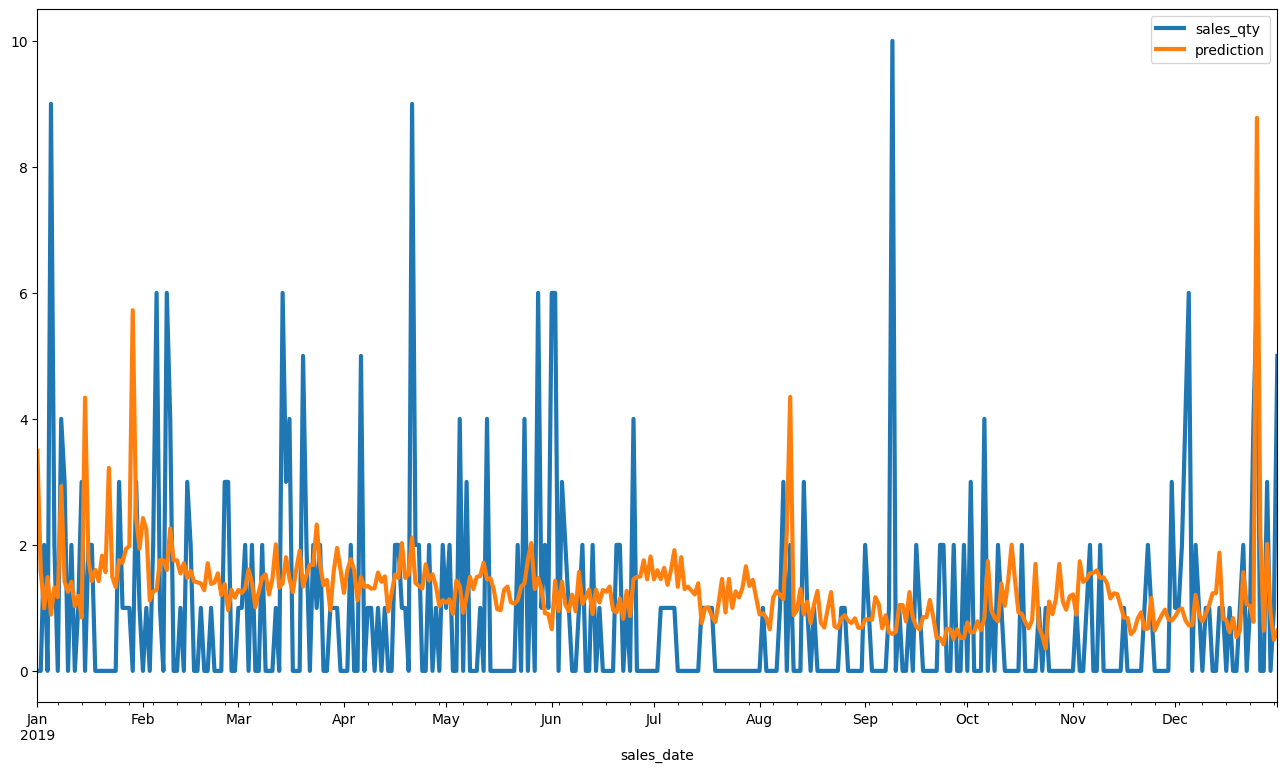

#### Item: Somersby ####
## Train & valid scores: 
WMAPE: 117.35
Bias: 7.95
## Test scores: 
WMAPE: 112.82
Bias: 9.9


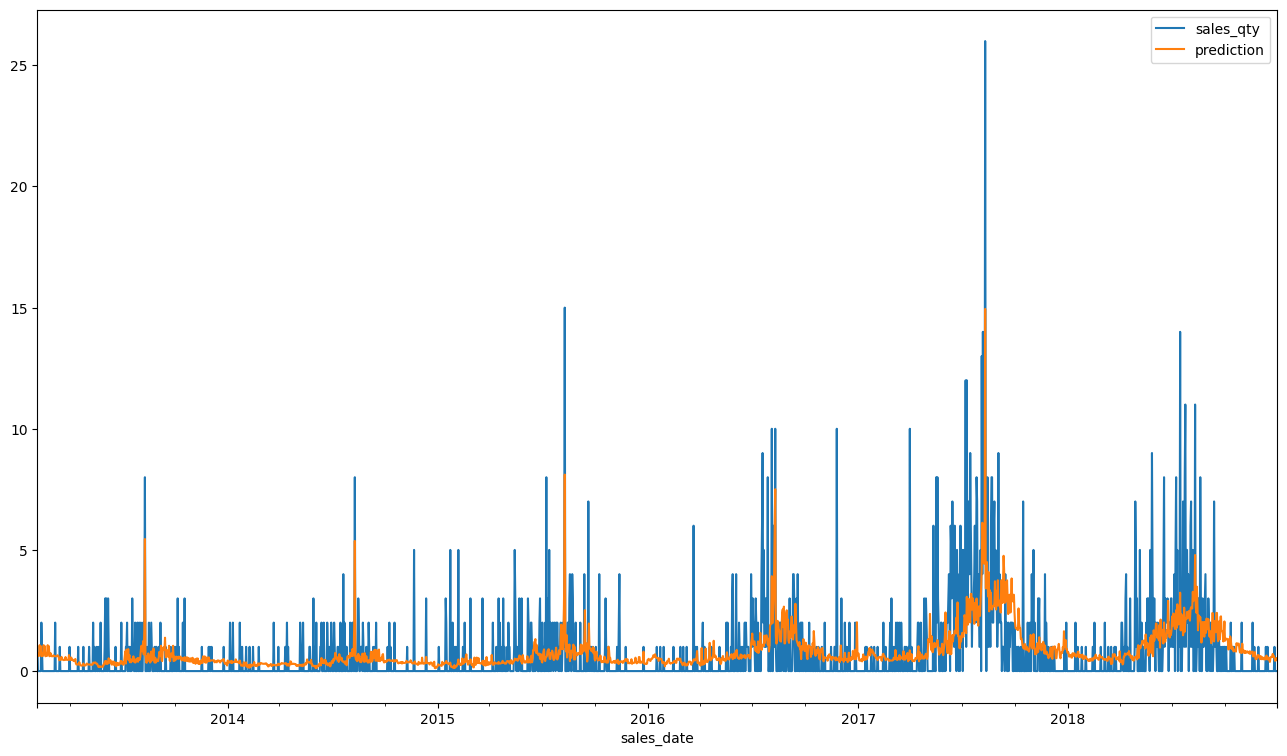

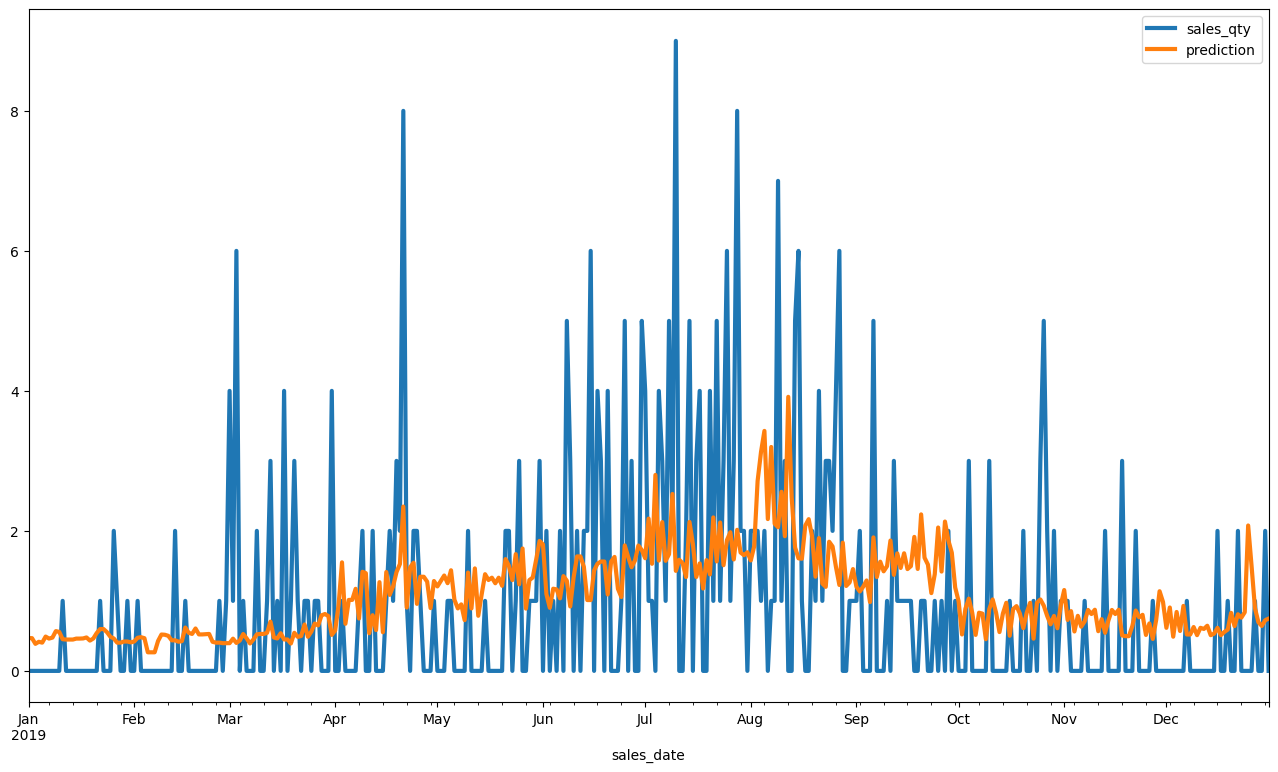

In [21]:
sort_by = 'wmape'
sort_ascending = False
plot_examples(dataset, 
              wmape_train_valid_scores, 
              wmape_test_scores,
              train_mask,
              valid_mask,
              test_mask,
              sort_by,
              sort_ascending,
              num_examples=5)

### Examples with most bias

#### Item: Kakao ####
## Train & valid scores: 
WMAPE: 94.75
Bias: 7.67
## Test scores: 
WMAPE: 135.74
Bias: 53.12


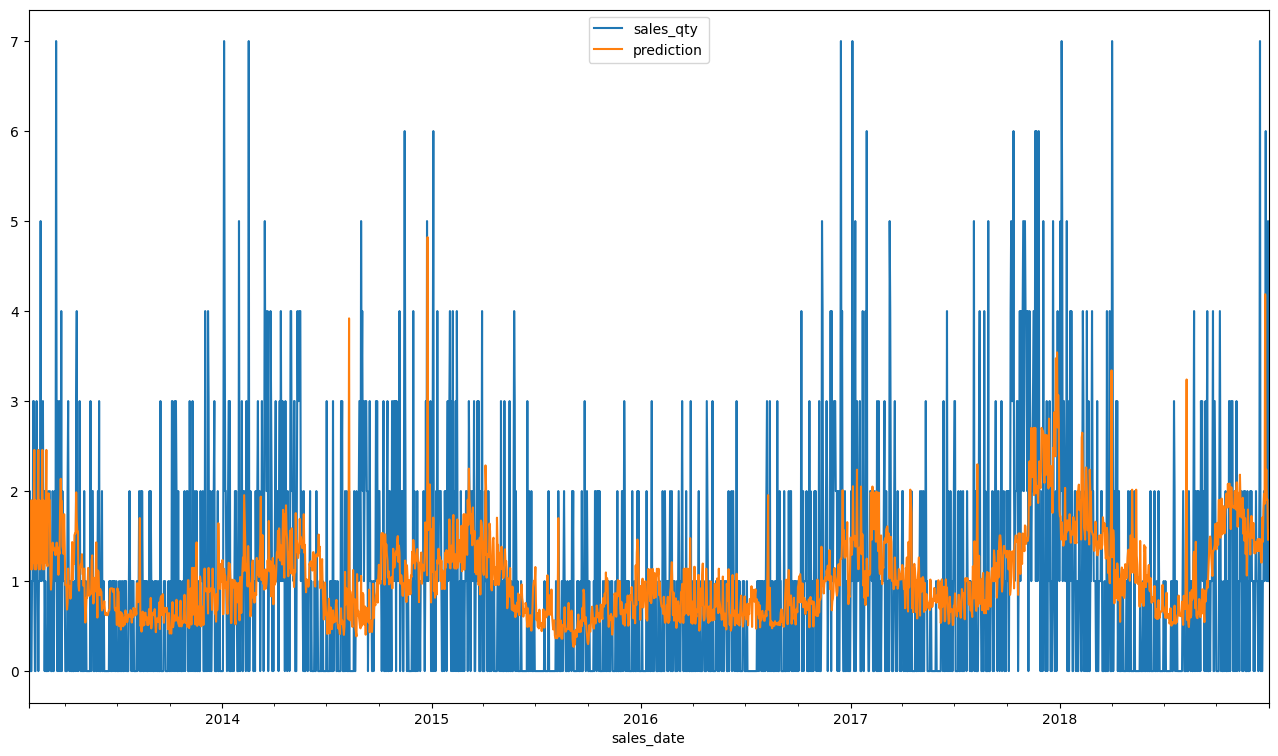

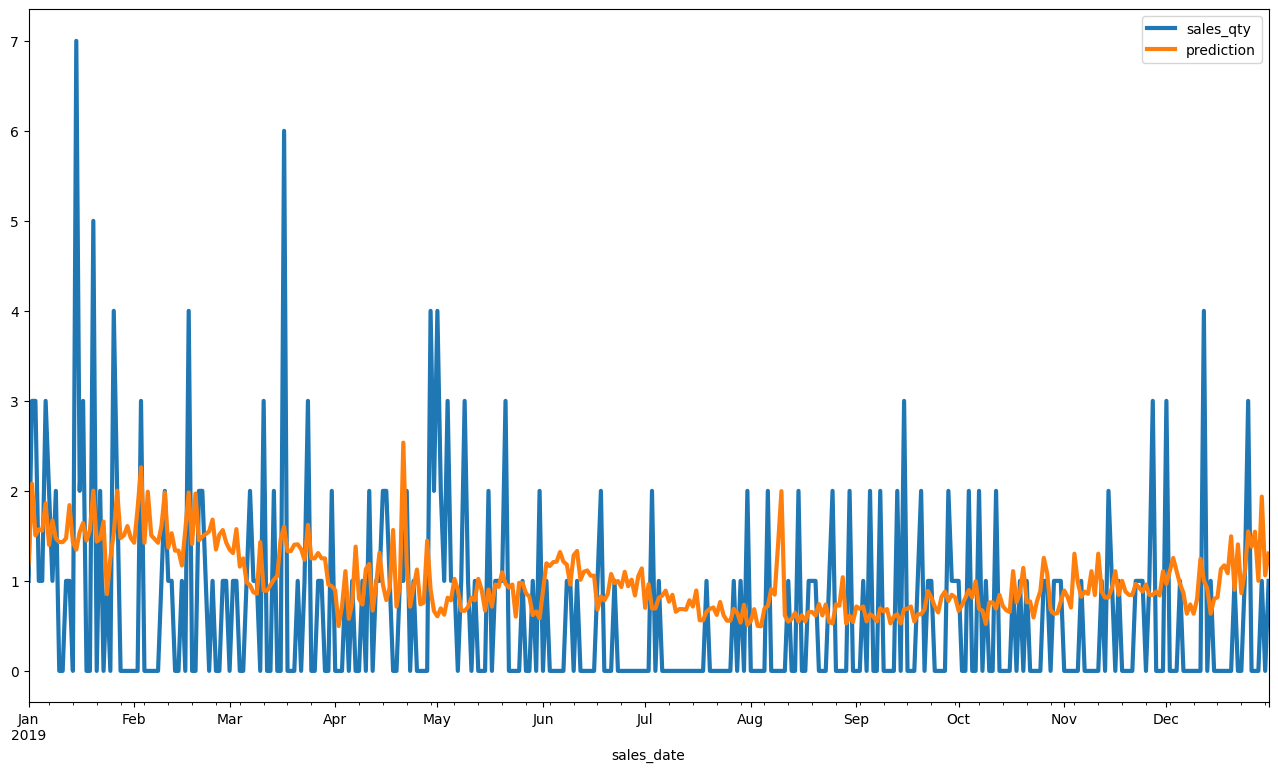

#### Item: Cappuccino ####
## Train & valid scores: 
WMAPE: 68.53
Bias: 8.57
## Test scores: 
WMAPE: 98.63
Bias: 48.86


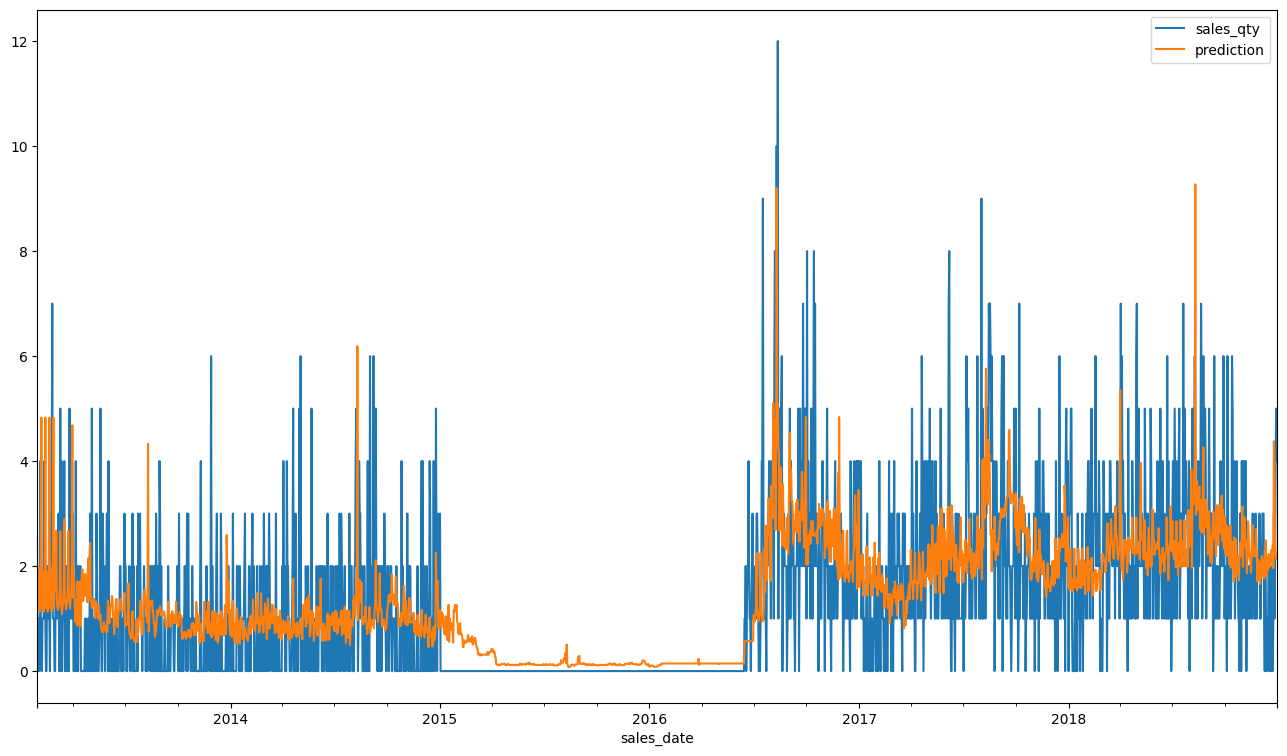

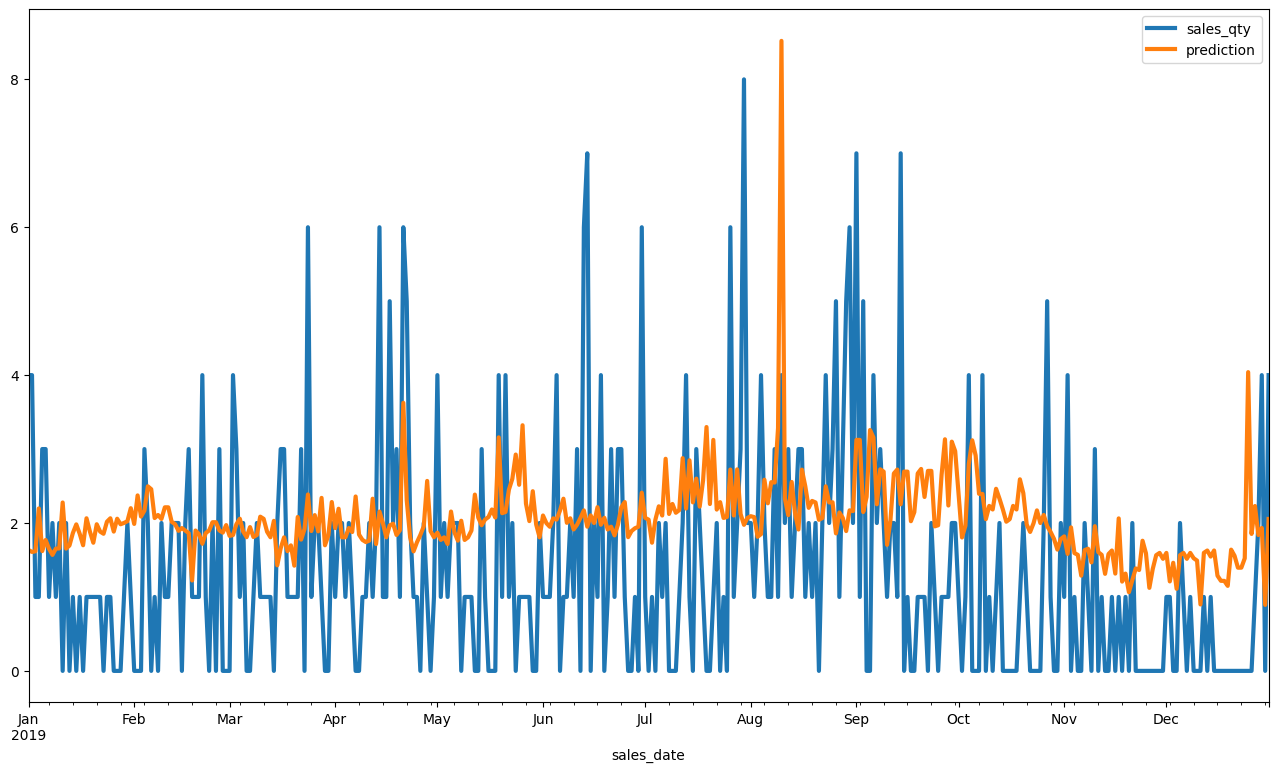

#### Item: Budweiser ####
## Train & valid scores: 
WMAPE: 61.55
Bias: 0.44
## Test scores: 
WMAPE: 88.22
Bias: 43.06


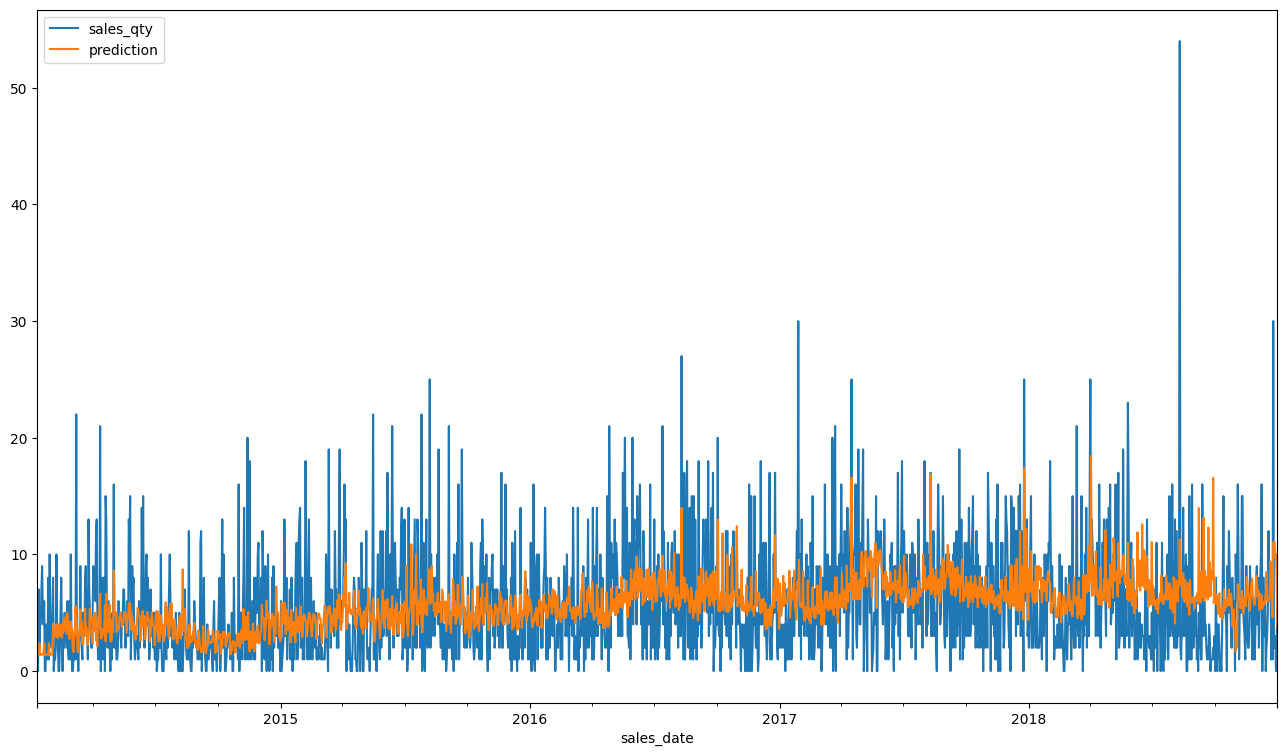

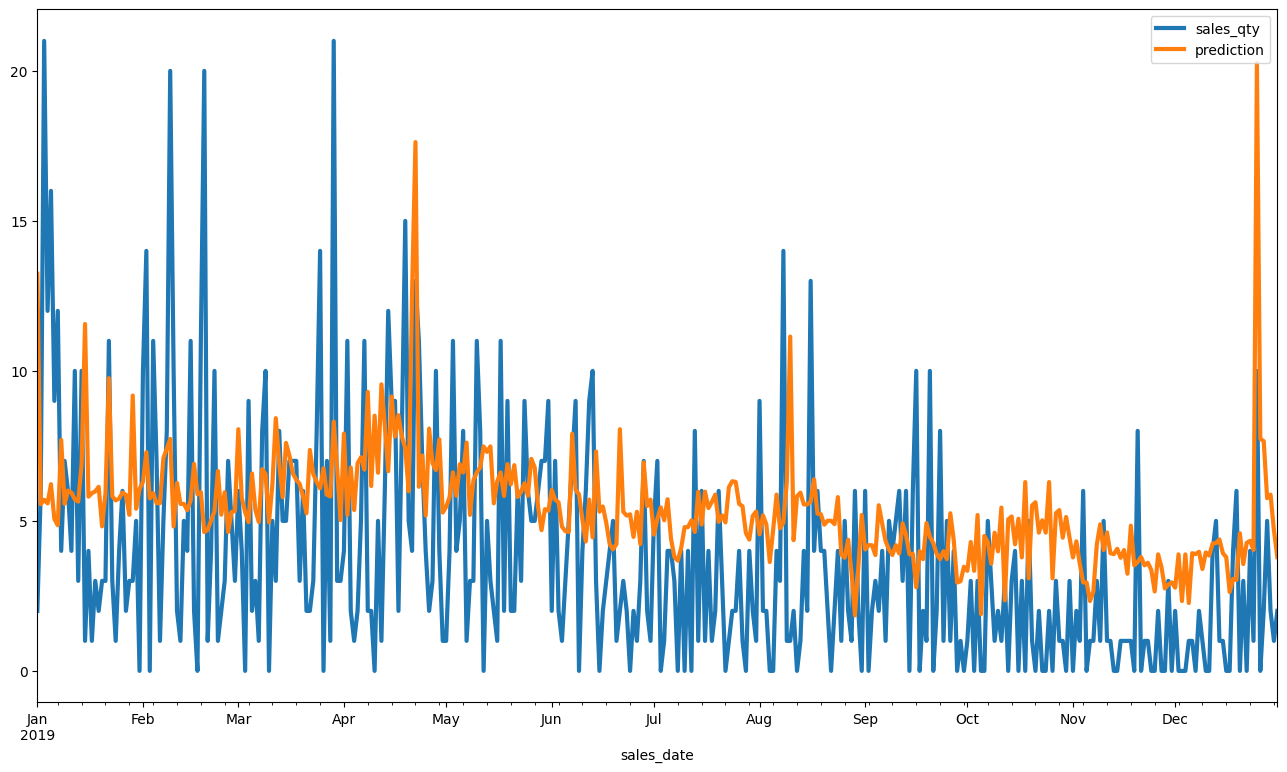

#### Item: Pelinkovac ####
## Train & valid scores: 
WMAPE: 145.17
Bias: 15.48
## Test scores: 
WMAPE: 133.58
Bias: 38.97


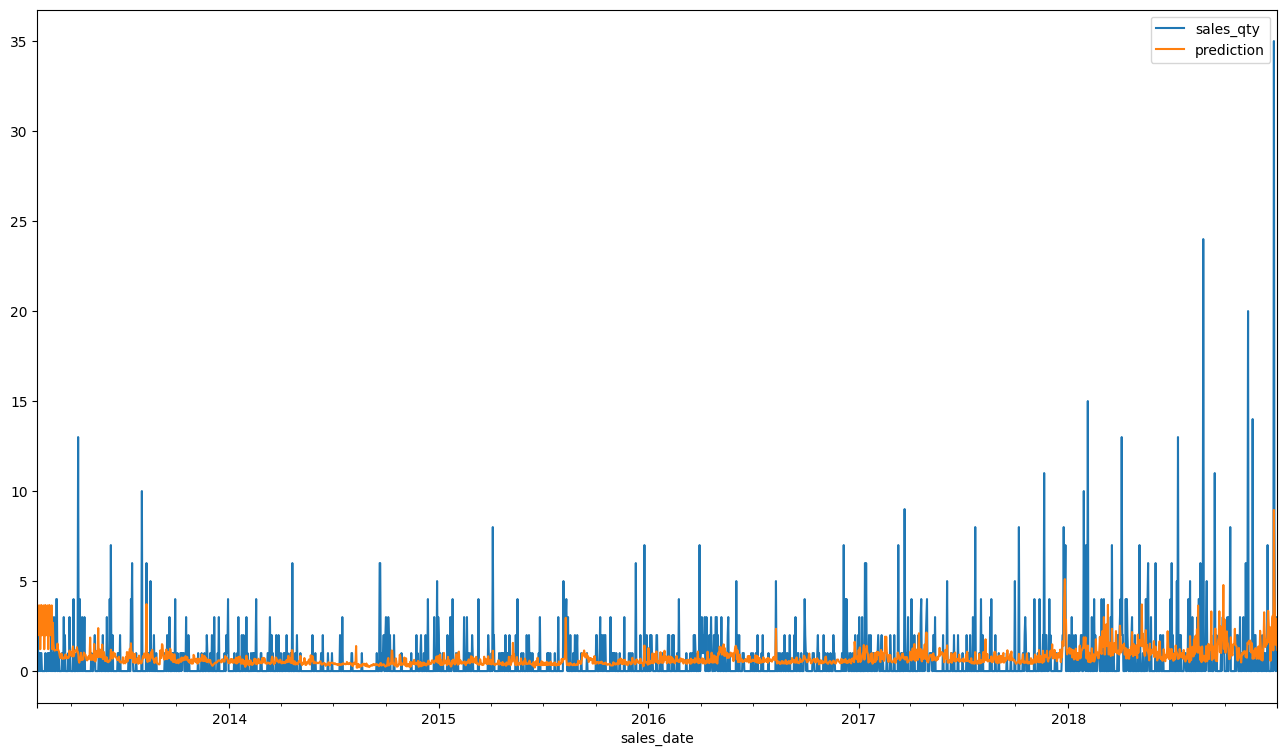

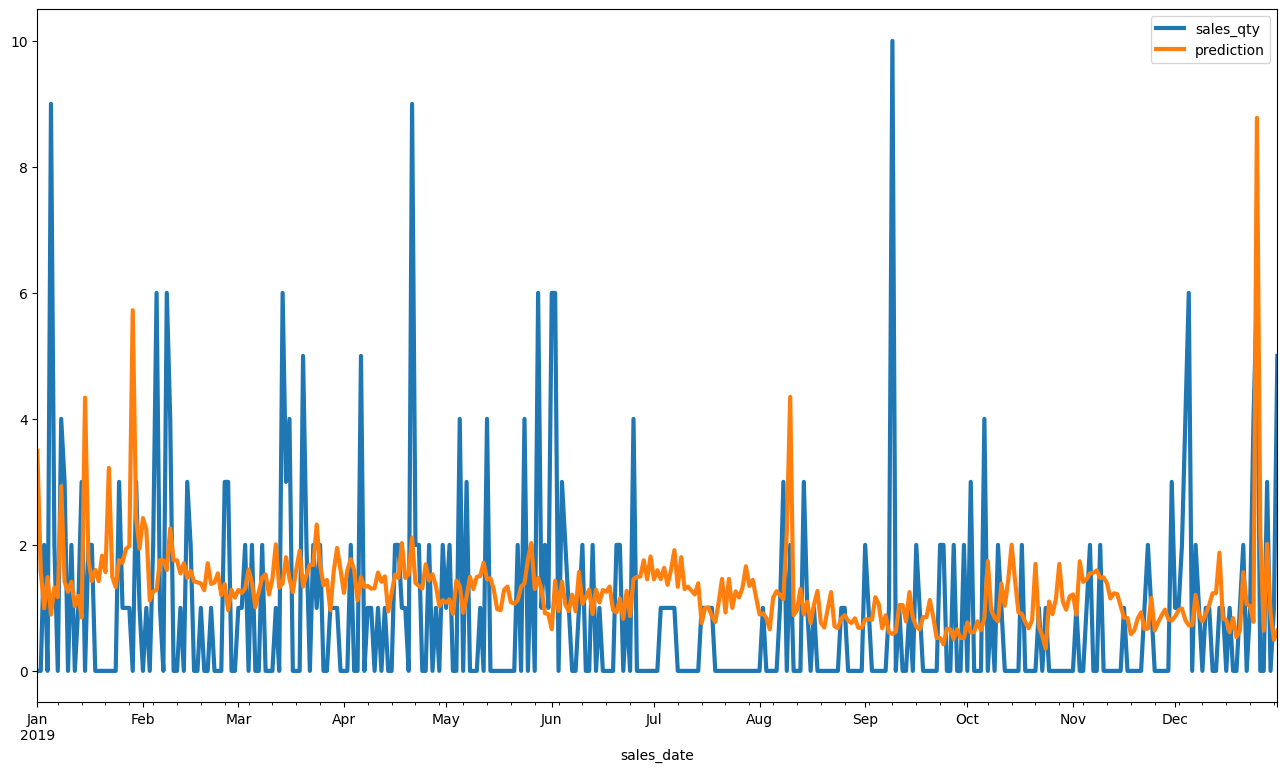

#### Item: Vino  0,2 l ####
## Train & valid scores: 
WMAPE: 123.81
Bias: -0.81
## Test scores: 
WMAPE: 160.39
Bias: 34.39


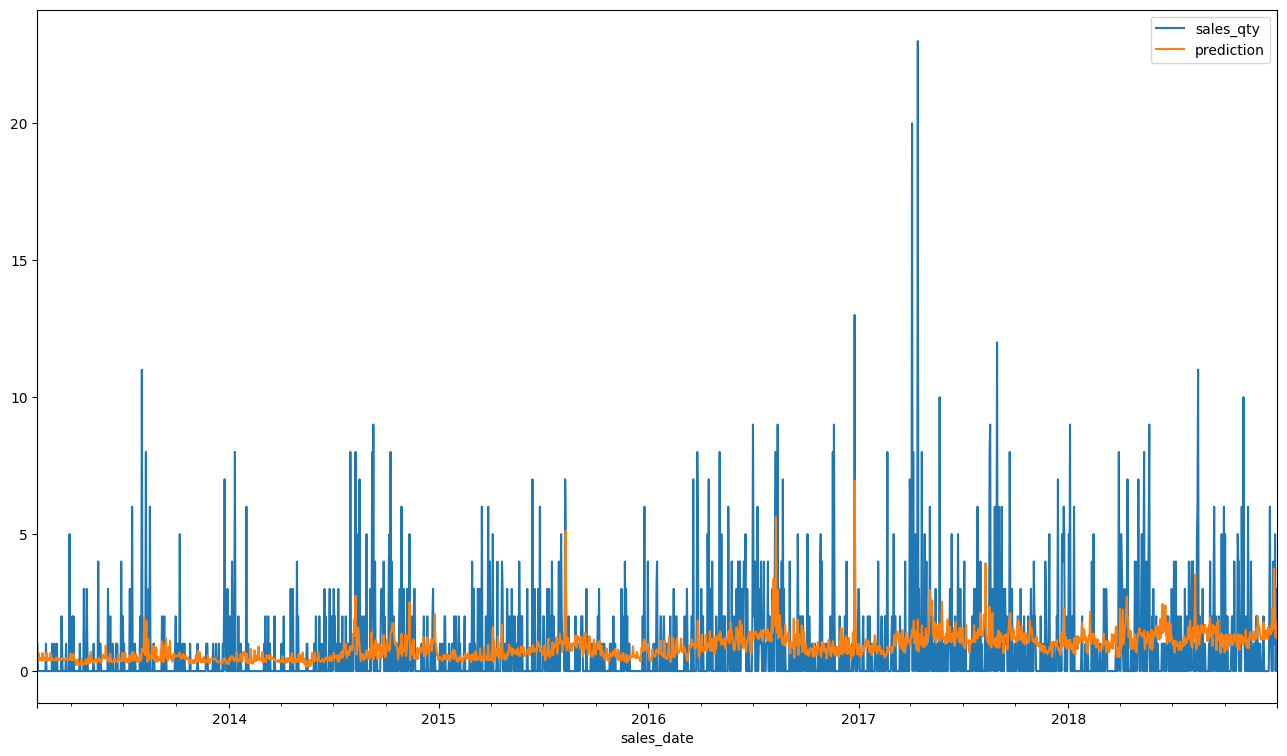

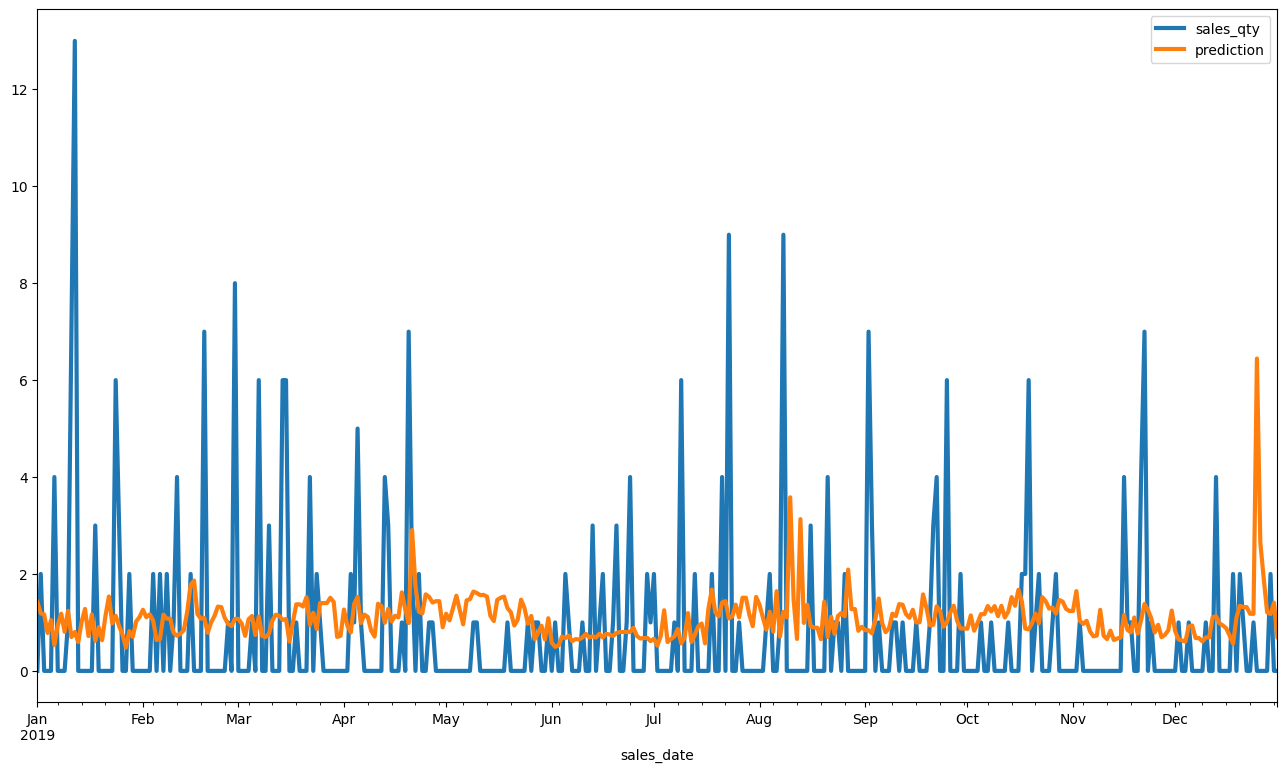

In [22]:
sort_by = 'bias'
sort_ascending = False
plot_examples(dataset, 
              wmape_train_valid_scores, 
              wmape_test_scores,
              train_mask,
              valid_mask,
              test_mask,
              sort_by,
              sort_ascending,
              num_examples=5)

## Shapley values

### Feature importances

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


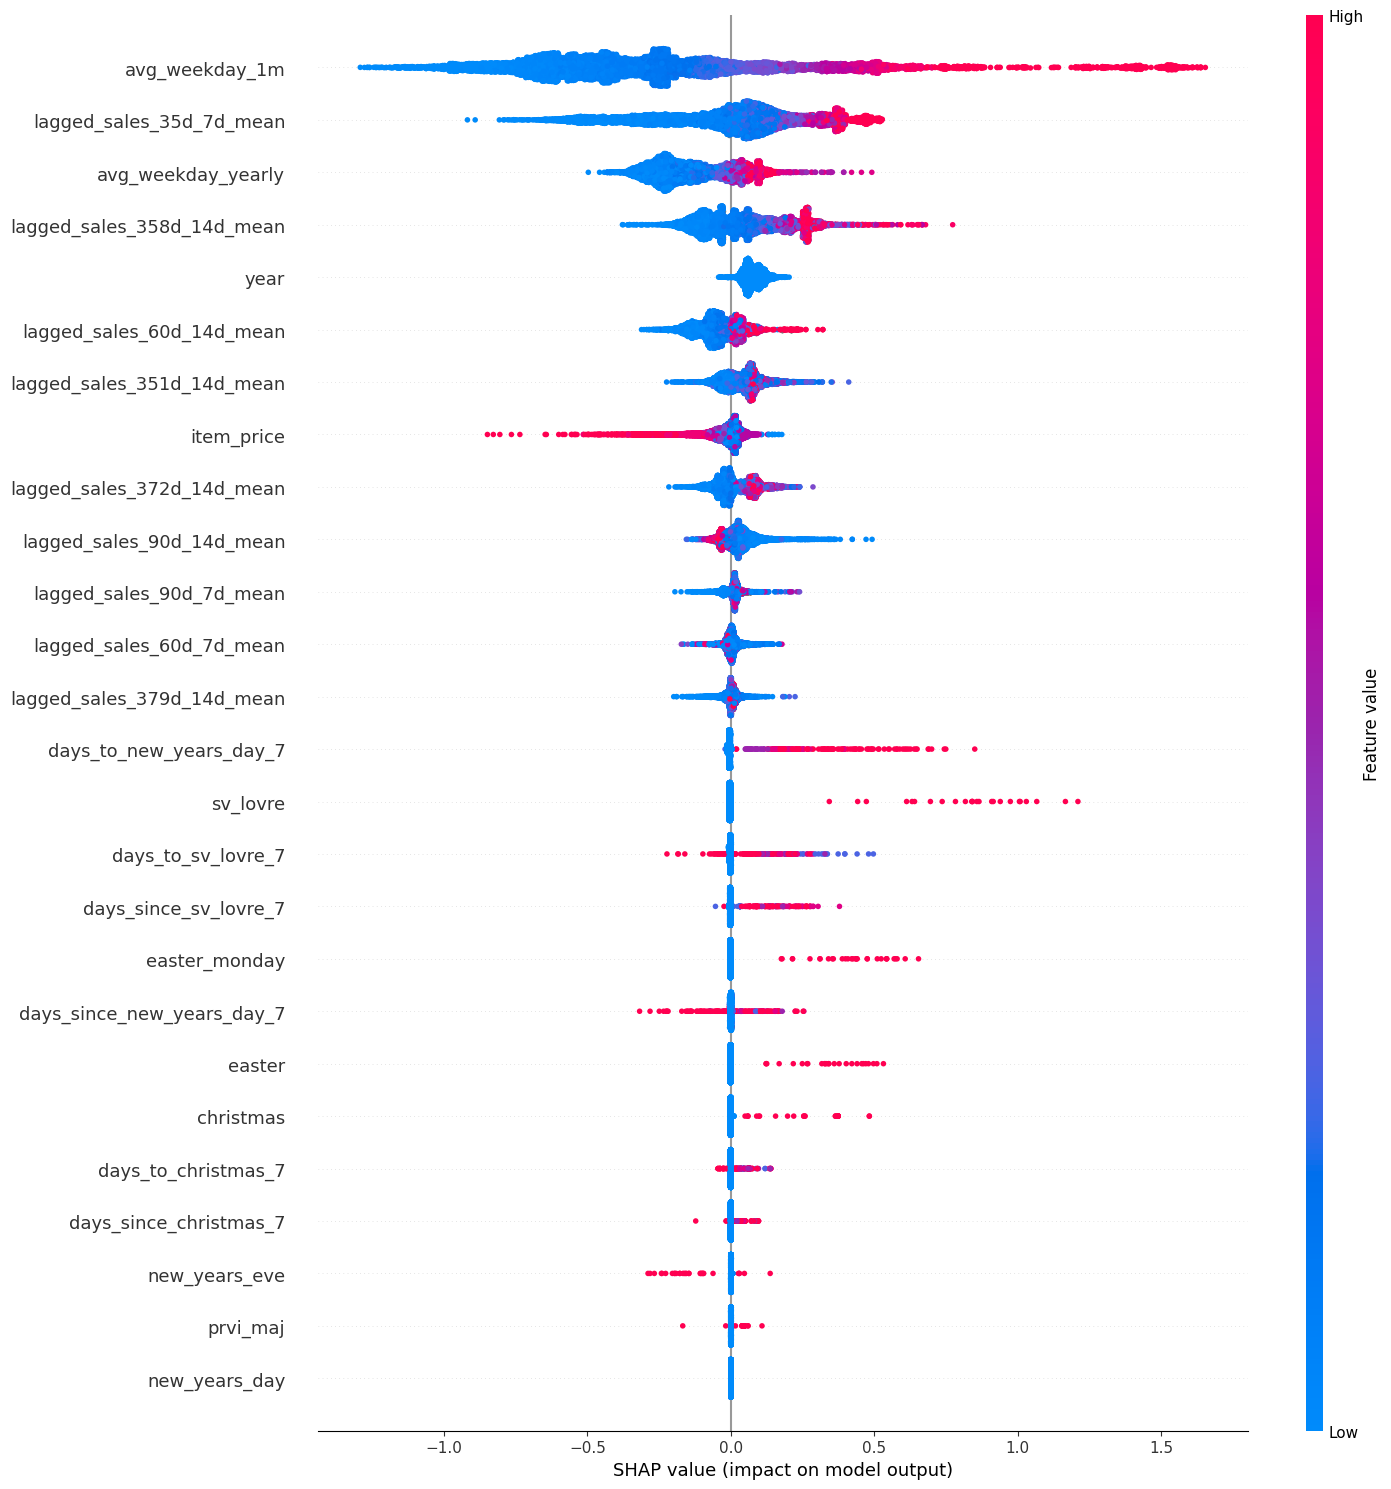

In [23]:
subsample_size = 10000

explainer = shap.TreeExplainer(booster)

df_sample = dataset[valid_mask][booster.feature_names].sample(subsample_size)

shap_values = explainer(df_sample)

shap.summary_plot(shap_values.values, df_sample, max_display=60, show=True, plot_size=[15,15])
plt.show()

In [24]:
dataset.item_name.unique()

array(['Beck`s', 'Bijela kava', 'Budweiser', 'Cappuccino', 'Cedevita',
       'Coca Cola', 'Cockta', 'Emotion', 'Jamnica sensation', 'Juicy',
       'Kakao', 'Karlovaèko Hajduk', 'Karlovaèko pivo', 'Kava',
       'Kava s mlijekom', 'Kava s mlijekom velika',
       'Kava sa \x9alagom velika', 'Ledeni Èaj', 'Limona',
       'Mineralna voda', 'Nescaffe', 'Nik\x9aièko', 'Orahovac',
       'O\x9eujsko', 'Pelinkovac', 'Pipi', 'Prirodni sokovi', 'Schweppes',
       'Somersby', 'Spezi+kava', 'Staropramen', 'Stella Artois',
       'Velika kava s \x9alagom', 'Vino  0,2 l', 'Vi\x9anjevaèa', 'Vodka',
       'Zlatni Pan', 'Èaj', 'Èaj s limunom i medom',
       'Jana vitaminski napitak'], dtype=object)

### Waterfall graph for selected prediction

Item name:       Kava
Prediction date: 2019-12-24

Predicted value:                                          16.2
Sales quantity:                                      29.000000



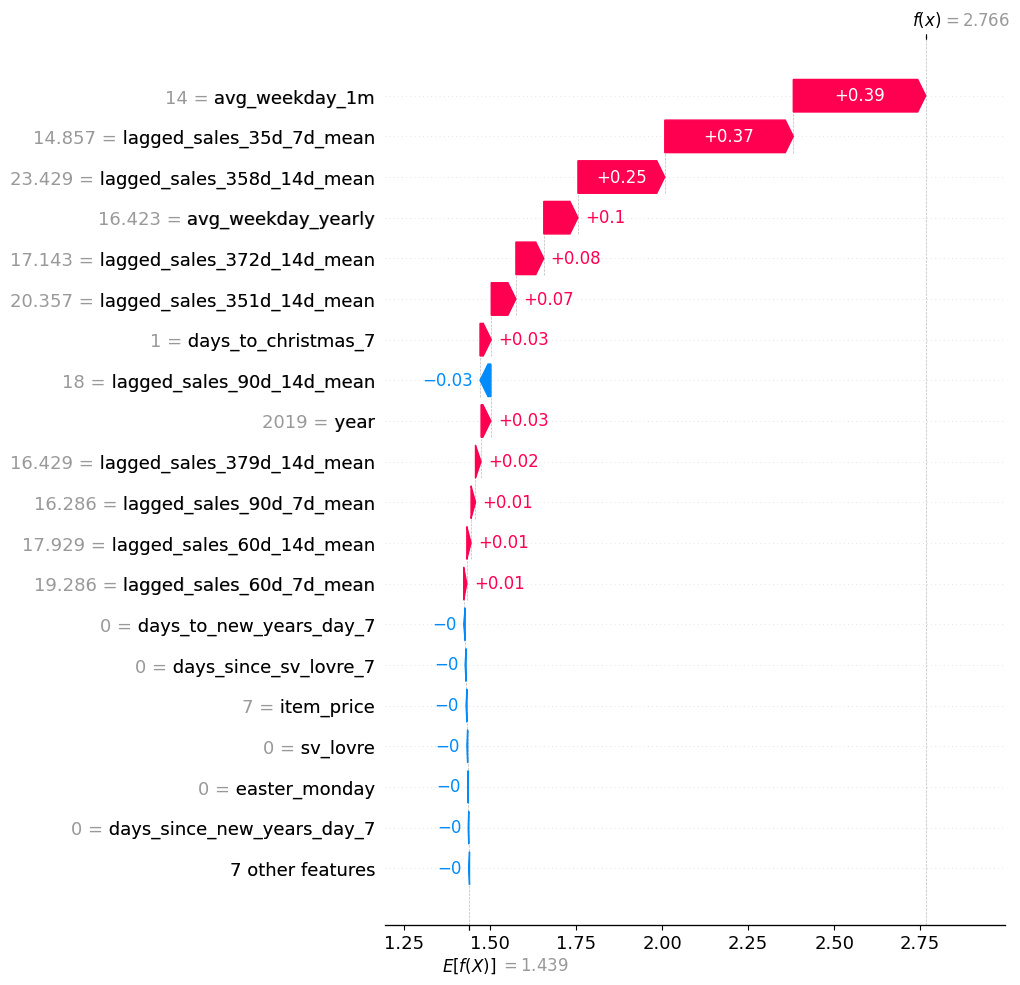

In [25]:
ITEM_NAME = 'Kava'
PREDICTION_DATE = '2019-12-24'

mask = (dataset['item_name'] == ITEM_NAME) & (dataset.index == PREDICTION_DATE)

explainer = shap.TreeExplainer(booster)
shap_values = explainer(dataset[mask][booster.feature_names])

prediction = dataset[mask]['prediction'].iloc[0]
sales_quantity = dataset[mask]['sales_qty'].iloc[0]

print(f'Item name:       {ITEM_NAME}')
print(f'Prediction date: {PREDICTION_DATE}')
print()
print(f'Predicted value:                                          {prediction:.1f}')
print(f'Sales quantity:                                      {sales_quantity:4f}')
print()

shap.plots.waterfall(shap_values[0], max_display=20)

# Comparison of model with short-term MA

In [27]:
wmape_train = wmape(dataset[train_mask]['sales_qty'], dataset[train_mask]['lagged_sales_35d_7d_mean'])
wmape_test = wmape(dataset[test_mask]['sales_qty'], dataset[test_mask]['lagged_sales_35d_7d_mean'])

bias_train = wbias(dataset[train_mask]['sales_qty'], dataset[train_mask]['lagged_sales_35d_7d_mean'])
bias_test = wbias(dataset[test_mask]['sales_qty'], dataset[test_mask]['lagged_sales_35d_7d_mean'])

print("Train WMAPE:", wmape_train)
print("Test WMAPE:", wmape_test)
print("Train bias:", bias_train)
print("Test bias:", bias_test)

Train WMAPE: 49.28
Test WMAPE: 47.73
Train bias: -0.92
Test bias: 1.07


In [30]:
wmape_test_scores_ma = dataset[test_mask].groupby('item_name').apply(lambda x: pd.Series({'bias_ma': wbias(x['sales_qty'], x['lagged_sales_35d_7d_mean']), 
                                                                'wmape_ma': wmape(x['sales_qty'], x['lagged_sales_35d_7d_mean']),
                                                                'total_prediction_ma': x['lagged_sales_35d_7d_mean'].sum()})
                                                                ).sort_values(by='total_prediction_ma', ascending=False).reset_index()

In [34]:
merged_test_scores = wmape_test_scores.merge(wmape_test_scores_ma, how='left', on='item_name')

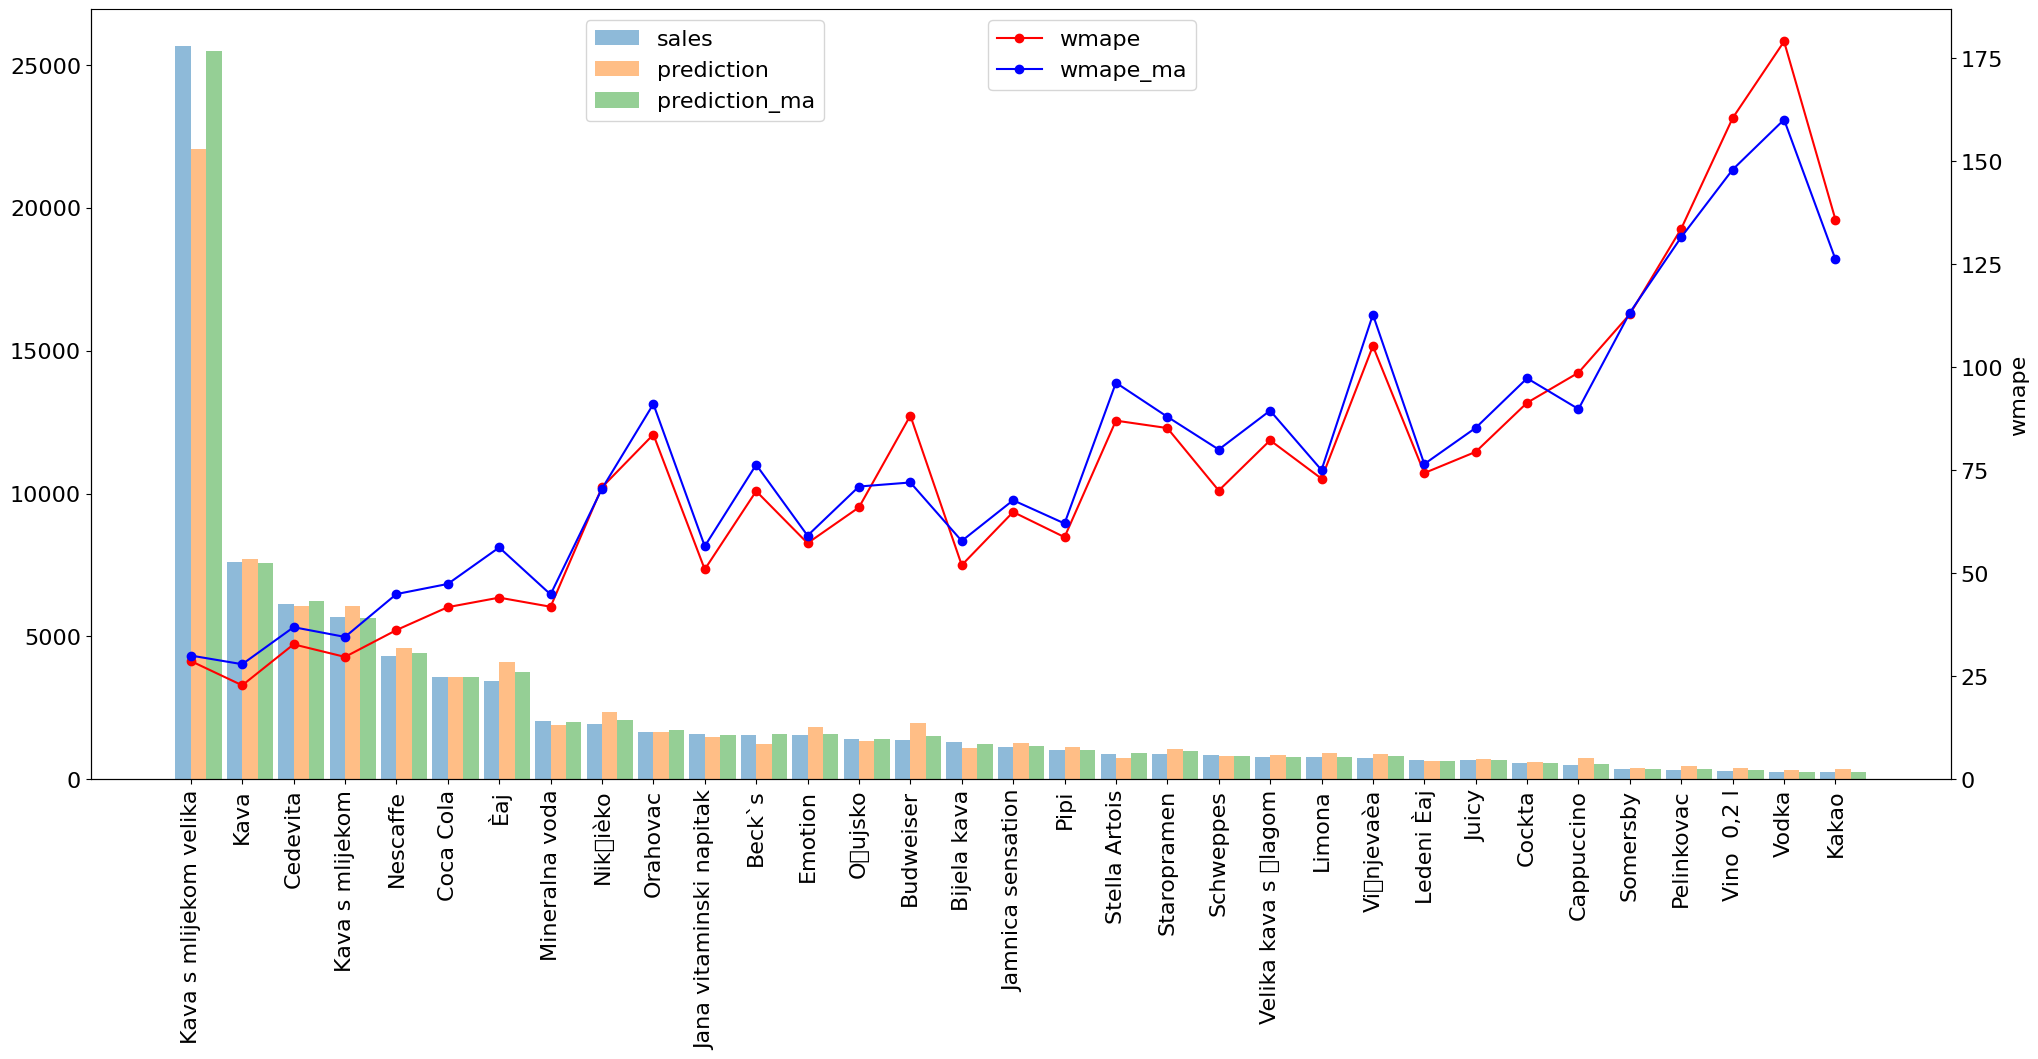

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(24,10))

X_axis = np.arange(len(merged_test_scores['item_name']))
p1 = ax.bar(X_axis - 0.15, merged_test_scores['total_sales'], width=0.3, alpha=0.5, label='sales')
p2 = ax.bar(X_axis + 0.15, merged_test_scores['total_prediction'], width=0.3, alpha=0.5, label='prediction')
p2 = ax.bar(X_axis + 0.45, merged_test_scores['total_prediction_ma'], width=0.3, alpha=0.5, label='prediction_ma')
ax.spines['top'].set_visible(False)
ax.set_xticks(X_axis)
ax.set_xticklabels(merged_test_scores['item_name'], rotation=90, fontsize=16)
ax.tick_params(axis='y', labelsize=16)


ax2 = ax.twinx()
p3 = ax2.plot(X_axis, merged_test_scores['wmape'], color = 'red', marker='o', label='wmape')
p3 = ax2.plot(X_axis, merged_test_scores['wmape_ma'], color = 'blue', marker='o', label='wmape_ma')
ax2.set_ylabel('wmape', fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax.legend(bbox_to_anchor=(0.4, 1), fontsize=16)
ax2.legend(bbox_to_anchor=(0.6, 1), fontsize=16)